# Importación y fusión de los archivos CSV

In [471]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [472]:
#pip install protobuf==3.20.0

In [473]:
#pip install smdebug

In [474]:
print(pd.__version__,np.__version__)

2.0.3 1.22.3


In [475]:
columns=['Factura','Fecha','Venta Neta','Cantidad','Costo Venta','ClienteID']

In [476]:
df1 = pd.read_csv("maestro_facturas_ventas_1.csv", sep=";")
df2 =  pd.read_csv("maestro_facturas_ventas_2.csv", sep=";")
df_concat = pd.concat([df1, df2], ignore_index=True)

Columns (0,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.


In [477]:
df_concat.shape

(1853848, 7)

In [478]:
df =df_concat[['exportar[FACTURA]','exportar[FECHA]','[VENTA_NETA]','[CANTBASE]','[COSTO_VENTA_COL]','CLIENTE_COD_PROCESADO']].copy()
df.columns = columns

In [479]:
df.head()

,Factura,Fecha,Venta Neta,Cantidad,Costo Venta,ClienteID
0,121563945,2020-01-02T00:00:00,8160.0,3.0,7169.85,9000000
1,121563984,2020-01-02T00:00:00,7217.66,1.0,7191.03,9000000
2,121564157,2020-01-02T00:00:00,14210.0,1.0,9873.01,9000000
3,121564388,2020-01-02T00:00:00,7805.0,1.0,5029.8,9000000
4,121564706,2020-01-02T00:00:00,8000.0,1.0,6420.49,9000000


In [480]:
df.isnull().sum(),df.isna().sum()

(Factura        0
 Fecha          0
 Venta Neta     0
 Cantidad       0
 Costo Venta    0
 ClienteID      0
 dtype: int64,
 Factura        0
 Fecha          0
 Venta Neta     0
 Cantidad       0
 Costo Venta    0
 ClienteID      0
 dtype: int64)

In [481]:
df.duplicated().sum()

36

In [482]:
df.drop_duplicates(inplace=True)

In [483]:
df[df['Factura']=='exportar[FACTURA]'].count()

Factura        1
Fecha          1
Venta Neta     1
Cantidad       1
Costo Venta    1
ClienteID      1
dtype: int64

In [484]:
df = df[df['Factura']!='exportar[FACTURA]']

In [485]:
df['Fecha']= df['Fecha'].str[:10]

In [486]:
df['Fecha']

0          2020-01-02
1          2020-01-02
2          2020-01-02
3          2020-01-02
4          2020-01-02
              ...    
1853843    2022-08-17
1853844    2022-08-17
1853845    2022-08-17
1853846    2022-08-17
1853847    2022-08-17
Name: Fecha, Length: 1853811, dtype: object

In [487]:
df['Fecha'] = pd.to_datetime(df['Fecha'])


In [488]:
type(df['Fecha'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [489]:
df['Fecha']

0         2020-01-02
1         2020-01-02
2         2020-01-02
3         2020-01-02
4         2020-01-02
             ...    
1853843   2022-08-17
1853844   2022-08-17
1853845   2022-08-17
1853846   2022-08-17
1853847   2022-08-17
Name: Fecha, Length: 1853811, dtype: datetime64[ns]

In [490]:
df= df.astype({'Factura':int,
               'Costo Venta':float,
               'Venta Neta':float,
               'Cantidad':float,
               'ClienteID':int
              }) 

In [491]:
df.dtypes

Factura                 int64
Fecha          datetime64[ns]
Venta Neta            float64
Cantidad              float64
Costo Venta           float64
ClienteID               int64
dtype: object

In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1853811 entries, 0 to 1853847
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Factura      int64         
 1   Fecha        datetime64[ns]
 2   Venta Neta   float64       
 3   Cantidad     float64       
 4   Costo Venta  float64       
 5   ClienteID    int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 99.0 MB


In [493]:
df.describe()

,Factura,Fecha,Venta Neta,Cantidad,Costo Venta,ClienteID
count,1.853811e+06,1853811,1.853811e+06,1.853811e+06,1.853811e+06,1.853811e+06
mean,1.227932e+08,2021-04-24 02:49:27.436486144,1.753691e+05,2.079648e+02,1.485079e+05,4.863596e+06
min,2.510819e+07,2020-01-02 00:00:00,7.000030e+03,1.000000e+00,1.000000e-02,1.000026e+06
25%,1.221882e+08,2020-08-28 00:00:00,1.535000e+04,1.000000e+00,1.172007e+04,4.000176e+06
50%,1.227999e+08,2021-04-26 00:00:00,3.455018e+04,3.000000e+00,2.676858e+04,4.001060e+06
75%,1.234022e+08,2021-12-15 00:00:00,1.154074e+05,1.800000e+01,9.309248e+04,9.000005e+06
max,1.239977e+08,2022-08-17 00:00:00,2.730640e+08,1.999590e+06,2.546478e+08,9.000073e+06
std,7.131891e+05,NaN,5.895341e+05,2.390946e+03,5.327998e+05,2.927474e+06


In [494]:
df['ClienteID'].nunique()

8665

# Diseño de características

Para comenzar, debemos cambiar la estructura del dataframe. Los clientes deben ser los índices y la información se debe resumir por mes. 

In [495]:
df_limpio = df[['Factura','Fecha','Venta Neta','ClienteID']].copy()

In [496]:
df_limpio.head()

,Factura,Fecha,Venta Neta,ClienteID
0,121563945,2020-01-02,8160.00,9000000
1,121563984,2020-01-02,7217.66,9000000
2,121564157,2020-01-02,14210.00,9000000
3,121564388,2020-01-02,7805.00,9000000
4,121564706,2020-01-02,8000.00,9000000


## Cálculo de Recency

Este es el valor más complicado de los 3 porque se debe contabilizar la actualidad con un punto de referencia. Aunque lo más sencillo es que fuera fijo, esto no se apega la realidad, ni es conveniente para aprovechar al máximo el CLV del cliente. Por lo que hacemos un punto de referencia fijo y calculamos R mensualmente. 

In [497]:
# Crear una columna que represente el primer día de cada mes
df_limpio['PrimerDiaDelMes'] = df_limpio['Fecha'].dt.to_period('M').dt.to_timestamp()

In [498]:
# Calcular el primer día del mes siguiente a las ventas del mes evaluado
df_limpio['PrimerDiaSiguienteMes'] = (df_limpio['Fecha'] + pd.DateOffset(months=1)).dt.to_period('M').dt.to_timestamp()

In [499]:
# Calcular la diferencia en días entre el primer día del mes siguiente y la fecha de compra
df_limpio['Recency'] = (df_limpio['PrimerDiaSiguienteMes'] - df_limpio['Fecha']).dt.days

In [500]:
df_limpio.head()

,Factura,Fecha,Venta Neta,ClienteID,PrimerDiaDelMes,PrimerDiaSiguienteMes,Recency
0,121563945,2020-01-02,8160.00,9000000,2020-01-01,2020-02-01,30
1,121563984,2020-01-02,7217.66,9000000,2020-01-01,2020-02-01,30
2,121564157,2020-01-02,14210.00,9000000,2020-01-01,2020-02-01,30
3,121564388,2020-01-02,7805.00,9000000,2020-01-01,2020-02-01,30
4,121564706,2020-01-02,8000.00,9000000,2020-01-01,2020-02-01,30


In [501]:
df_limpio['Recency'].value_counts()

Recency
4     71078
28    66645
3     66588
5     65346
18    64511
25    63986
11    63404
27    63254
20    62810
21    62773
26    62413
6     61975
19    61854
2     61517
1     61434
24    61195
14    60723
22    59614
23    59077
15    58942
13    58309
29    58006
12    57991
16    57543
9     56897
8     56026
7     55879
17    55875
30    55578
10    54961
31    27607
Name: count, dtype: int64

In [502]:
# Agrupa los datos por "ClienteID" y "PrimerDiaDelMes" y obtén el valor mínimo de Recency en cada grupo
rfm_recency = df_limpio.groupby(['ClienteID', 'PrimerDiaDelMes'])['Recency'].min().reset_index()

In [503]:
rfm_recency.head()

,ClienteID,PrimerDiaDelMes,Recency
0,1000026,2020-08-01,10
1,1000026,2020-09-01,21
2,1000026,2020-10-01,16
3,1000026,2020-11-01,5
4,1000026,2020-12-01,24


## Cálculo de la Frecuencia 

In [504]:
# Agrupa los datos por "ClienteID" y "Mes" y cuenta la cantidad de transacciones en cada grupo
rfm_frequency = df_limpio.groupby(['ClienteID', 'PrimerDiaDelMes'])['Factura'].count().reset_index()
rfm_frequency.rename(columns={'Factura': 'Frequency'}, inplace=True)

In [505]:
rfm_frequency.head()

,ClienteID,PrimerDiaDelMes,Frequency
0,1000026,2020-08-01,2
1,1000026,2020-09-01,1
2,1000026,2020-10-01,1
3,1000026,2020-11-01,4
4,1000026,2020-12-01,1


## Cálculo de Monetary

In [506]:
df_monetary = df_limpio.groupby(['ClienteID', 'PrimerDiaDelMes'])['Venta Neta'].sum().reset_index()

In [507]:
df_monetary.head()

,ClienteID,PrimerDiaDelMes,Venta Neta
0,1000026,2020-08-01,69320.00
1,1000026,2020-09-01,22959.86
2,1000026,2020-10-01,65720.00
3,1000026,2020-11-01,273843.71
4,1000026,2020-12-01,71360.00


## Ahora vamos a crear el conjunto de datos RFM_df fusionando los 3 df anteriores

In [508]:
df_monetary.shape,rfm_frequency.shape,rfm_recency.shape

((127709, 3), (127709, 3), (127709, 3))

In [509]:
# Fusiona los DataFrames para incluir todas las combinaciones de clientes y meses
rfm_df = df_monetary.merge(rfm_frequency, on=['ClienteID', 'PrimerDiaDelMes'])

In [510]:
rfm_df = rfm_df.merge(rfm_recency,on=['ClienteID', 'PrimerDiaDelMes'])

In [511]:
rfm_df.shape

(127709, 5)

In [512]:
rfm_df.rename(columns={"Recency": "R", "Frequency": "F",'Venta Neta':'M'},inplace=True)

In [513]:
rfm_df.head()

,ClienteID,PrimerDiaDelMes,M,F,R
0,1000026,2020-08-01,69320.00,2,10
1,1000026,2020-09-01,22959.86,1,21
2,1000026,2020-10-01,65720.00,1,16
3,1000026,2020-11-01,273843.71,4,5
4,1000026,2020-12-01,71360.00,1,24


## Fusión con instancias vacías 

Vamos a crear un dataframe con todas las combinaciones posibles para todos los clientes en todos los meses del dataframe

In [514]:
#unique_clients = df['ClienteID'].unique()
#unique_months = df_limpio['Fecha'].dt.to_period('M').dt.to_timestamp().unique()
#all_combinations = pd.DataFrame([(client, month) for client in unique_clients for month in unique_months], columns=['ClienteID', 'PrimerDiaDelMes'])

In [515]:
#all_combinations.head()

In [516]:
# Fusiona los DataFrames para incluir todas las combinaciones de clientes y meses
#rfm_completo = all_combinations.merge(rfm_df, on=['ClienteID', 'PrimerDiaDelMes'], how='left')

In [517]:
#rfm_completo.isna().sum(),rfm_completo.isnull().sum()

In [518]:
# Rellena los valores NaN con 0
#rfm_completo= rfm_completo.fillna(0)

In [519]:
rfm_df.isna().sum()

ClienteID          0
PrimerDiaDelMes    0
M                  0
F                  0
R                  0
dtype: int64

In [520]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127709 entries, 0 to 127708
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ClienteID        127709 non-null  int64         
 1   PrimerDiaDelMes  127709 non-null  datetime64[ns]
 2   M                127709 non-null  float64       
 3   F                127709 non-null  int64         
 4   R                127709 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 4.9 MB


# Tratamiento de los outliers

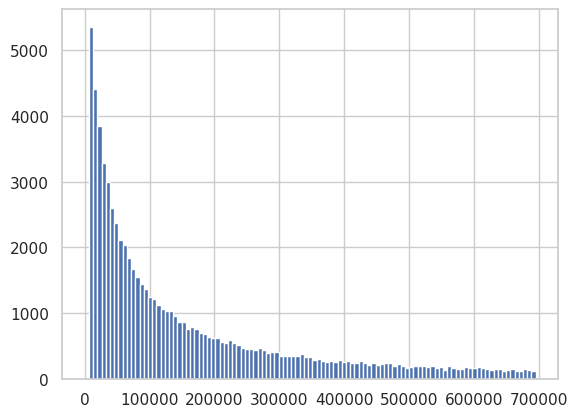

In [521]:
cuentas0, cajas0, ignored = plt.hist(rfm_df['M'], bins = np.arange(0,700000,6500))
plt.show()

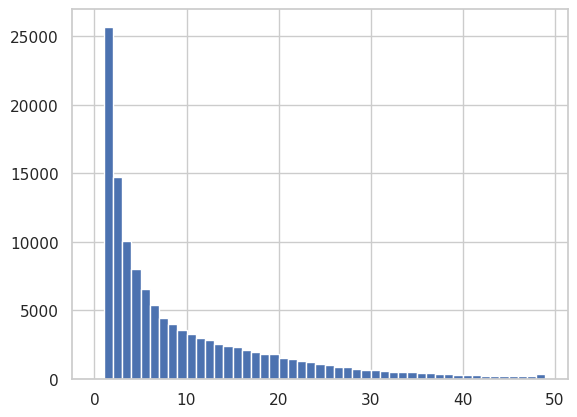

In [522]:
cuentas0, cajas0, ignored = plt.hist(rfm_df['F'], bins = np.arange(0,50,1))
plt.show()

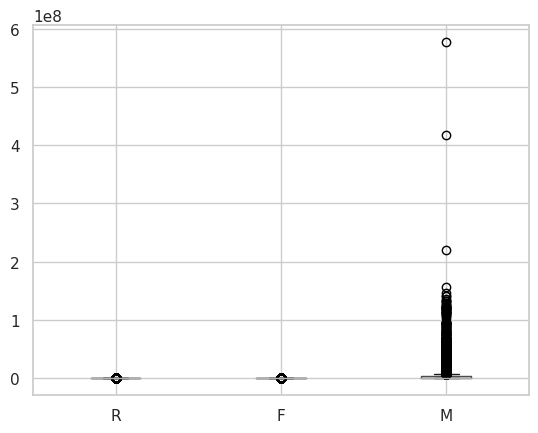

In [523]:
rfm_df[['R','F','M']].boxplot()
plt.show()

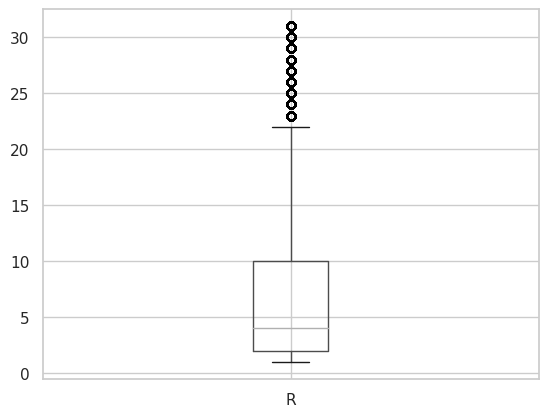

In [524]:
rfm_df[['R']].boxplot()
plt.show()

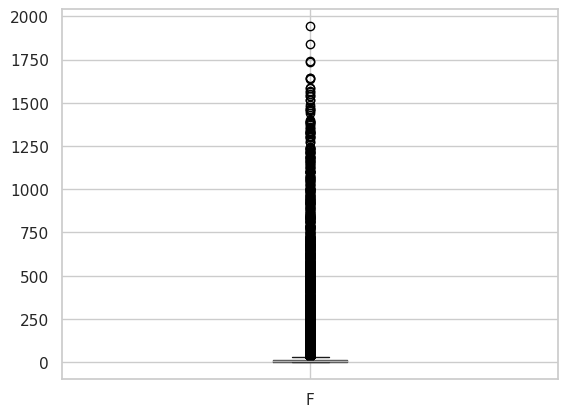

In [525]:
rfm_df[['F']].boxplot()
plt.show()

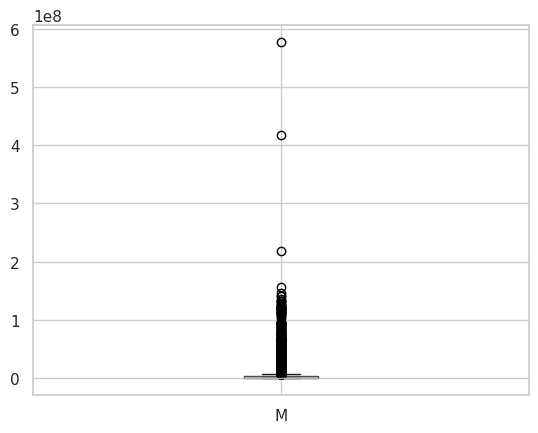

In [526]:
rfm_df[['M']].boxplot()
plt.show()

In [527]:
p25_m = np.percentile(rfm_df['M'], 25)
p75_m= np.percentile(rfm_df['M'], 75)
IQR_m = p75_m - p25_m
IQR_m

2620127.24

In [528]:
limite_inferior_m = p25_m - IQR_m
limite_superior_m = p75_m + 0.5*IQR_m
print('Limite superior: ', limite_superior_m)
print('Limite inferior: ', limite_inferior_m)

Limite superior:  4005577.7600000002
Limite inferior:  -2544740.3400000003


In [529]:
outliers = rfm_df[(rfm_df['M']<limite_inferior_m) | (rfm_df['M']>limite_superior_m)]
print('Outliers: ', len(outliers))

Outliers:  23345


In [530]:
rfm_filtrado = rfm_df.copy()

In [531]:
# Reemplazar los valores que superan el límite superior por 'limite_superior'
rfm_filtrado['M'] = np.where(rfm_df['M'] > limite_superior_m, np.nan, rfm_df['M'])

In [532]:
rfm_filtrado.isna().sum()

ClienteID              0
PrimerDiaDelMes        0
M                  23345
F                      0
R                      0
dtype: int64

In [533]:
p25_f = np.percentile(rfm_df['F'], 25)
p75_f= np.percentile(rfm_df['F'], 75)
IQR_f = p75_f - p25_f
IQR_f

12.0

In [534]:
limite_inferior_f = p25_f - 0.5*IQR_f
limite_superior_f = p75_f+ 0.5*IQR_f
print('Limite superior: ', limite_superior_f)
print('Limite inferior: ', limite_inferior_f)

Limite superior:  20.0
Limite inferior:  -4.0


In [535]:
# Reemplazar los valores que superan el límite superior por 'limite_superior'
rfm_filtrado['F'] = np.where(rfm_df['F'] >limite_superior_f, np.nan, rfm_df['F'])

In [536]:
rfm_filtrado.isna().sum()

ClienteID              0
PrimerDiaDelMes        0
M                  23345
F                  19714
R                      0
dtype: int64

In [537]:
rfm_filtrado.dropna(how="any",axis=0,inplace=True)

In [538]:
rfm_filtrado.isna().sum()

ClienteID          0
PrimerDiaDelMes    0
M                  0
F                  0
R                  0
dtype: int64

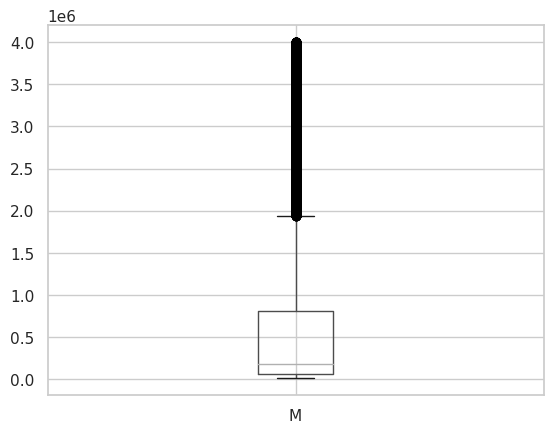

In [539]:
rfm_filtrado[['M']].boxplot()
plt.show()


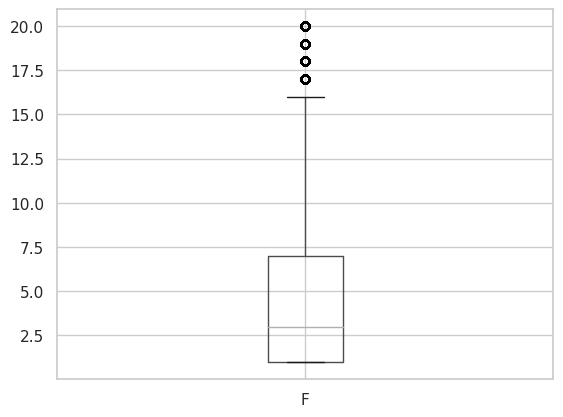

In [540]:
rfm_filtrado[['F']].boxplot()
plt.show()


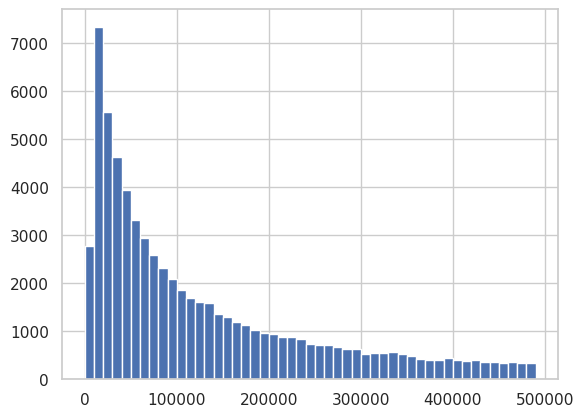

In [541]:
cuentas0, cajas0, ignored = plt.hist(rfm_filtrado['M'], bins = np.arange(0,500000,10000))
plt.show()

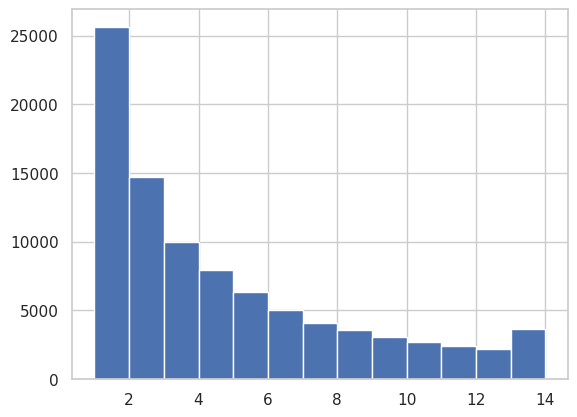

In [542]:
cuentas0, cajas0, ignored = plt.hist(rfm_filtrado['F'], bins = np.arange(1,15,1))
plt.show()

In [543]:
rfm_filtrado.head()

,ClienteID,PrimerDiaDelMes,M,F,R
0,1000026,2020-08-01,69320.00,2.0,10
1,1000026,2020-09-01,22959.86,1.0,21
2,1000026,2020-10-01,65720.00,1.0,16
3,1000026,2020-11-01,273843.71,4.0,5
4,1000026,2020-12-01,71360.00,1.0,24


## Escalado de las variables RFM 

In [544]:
from sklearn.preprocessing import MaxAbsScaler
MAS = MaxAbsScaler()

In [545]:
rfm_filtrado['Mes'] = rfm_filtrado['PrimerDiaDelMes'].dt.month

In [546]:
rfm_filtrado.head()

,ClienteID,PrimerDiaDelMes,M,F,R,Mes
0,1000026,2020-08-01,69320.00,2.0,10,8
1,1000026,2020-09-01,22959.86,1.0,21,9
2,1000026,2020-10-01,65720.00,1.0,16,10
3,1000026,2020-11-01,273843.71,4.0,5,11
4,1000026,2020-12-01,71360.00,1.0,24,12


In [547]:
rfm_transformado= rfm_filtrado.copy()
rfm_transformado[['R_score','F_score','M_score','Mes escalado']]=0

In [548]:
rfm_transformado.head()

,ClienteID,PrimerDiaDelMes,M,F,R,Mes,R_score,F_score,M_score,Mes escalado
0,1000026,2020-08-01,69320.00,2.0,10,8,0,0,0,0
1,1000026,2020-09-01,22959.86,1.0,21,9,0,0,0,0
2,1000026,2020-10-01,65720.00,1.0,16,10,0,0,0,0
3,1000026,2020-11-01,273843.71,4.0,5,11,0,0,0,0
4,1000026,2020-12-01,71360.00,1.0,24,12,0,0,0,0


In [549]:
variables_trans = ['R_score','F_score','M_score','Mes escalado']
variables_a_trans = ['R','F','M','Mes']

rfm_transformado[variables_trans] = MAS.fit_transform(rfm_transformado[variables_a_trans])

In [550]:
# Aplica la transformación a la columna 'R_score'
rfm_transformado['R_score'] = np.where(rfm_transformado['R_score'] > 0, 1 - rfm_transformado['R_score'], 0)

In [551]:
rfm_transformado.tail()

,ClienteID,PrimerDiaDelMes,M,F,R,Mes,R_score,F_score,M_score,Mes escalado
127661,9000072,2021-05-01,2953730.36,20.0,4,5,0.870968,1.00,0.737417,0.416667
127664,9000072,2021-08-01,1247312.90,19.0,2,8,0.935484,0.95,0.311399,0.666667
127669,9000072,2022-01-01,803417.23,15.0,3,1,0.903226,0.75,0.200578,0.083333
127671,9000072,2022-03-01,2711744.80,20.0,3,3,0.903226,1.00,0.677004,0.250000
127676,9000072,2022-08-01,959417.57,9.0,22,8,0.290323,0.45,0.239525,0.666667


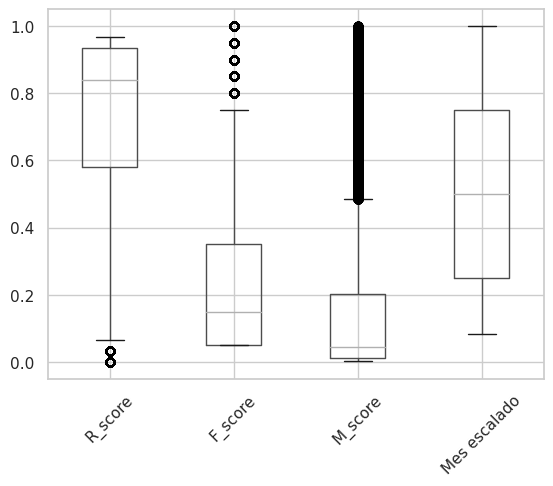

In [552]:
rfm_transformado[variables_trans].boxplot()
plt.xticks(rotation=45)
plt.show()

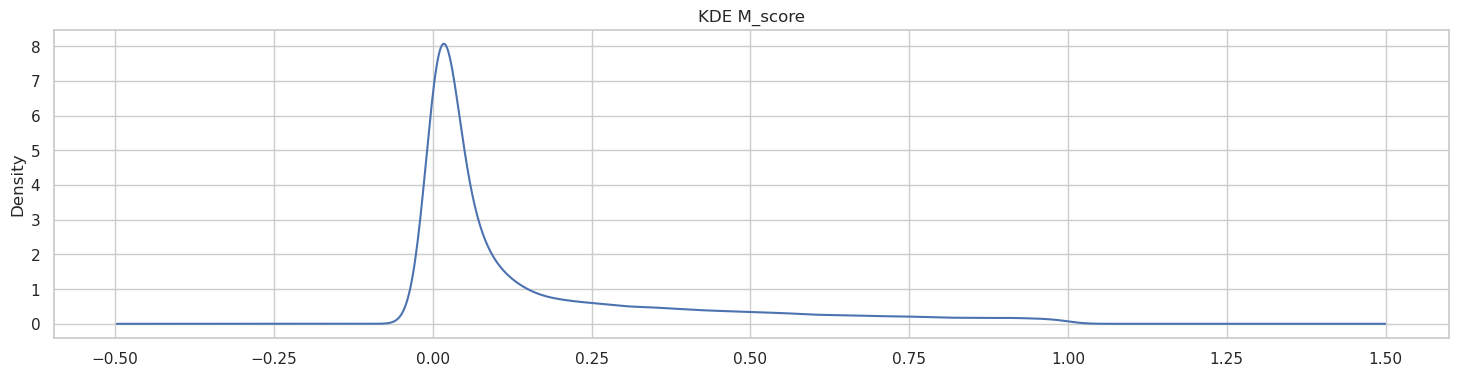

In [553]:
rfm_transformado['M_score'].plot( kind='kde',label = 'M_score', figsize=(18,4))
plt.title('KDE M_score')
plt.show()

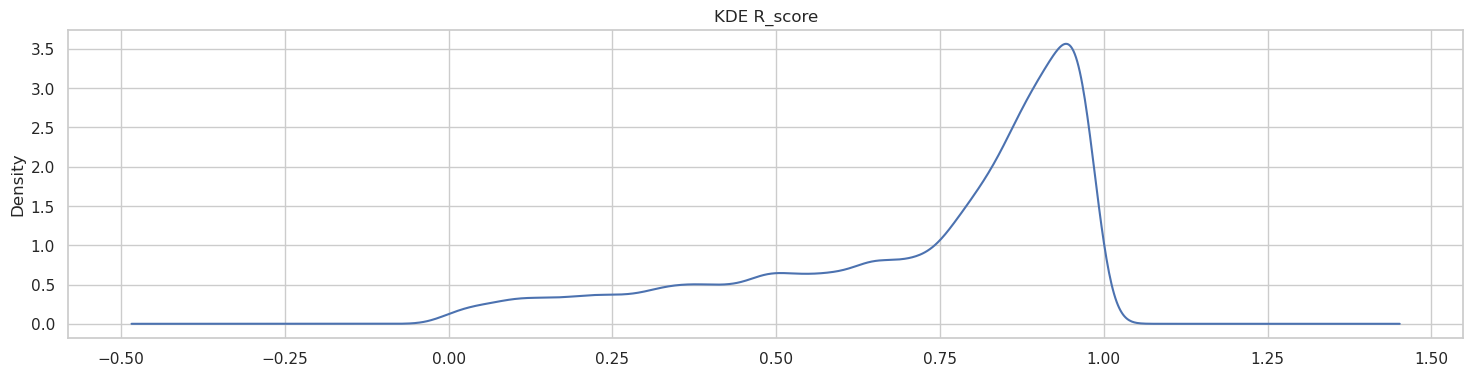

In [554]:
rfm_transformado['R_score'].plot( kind='kde',label = 'R_score', figsize=(18,4))
plt.title('KDE R_score')
plt.show()

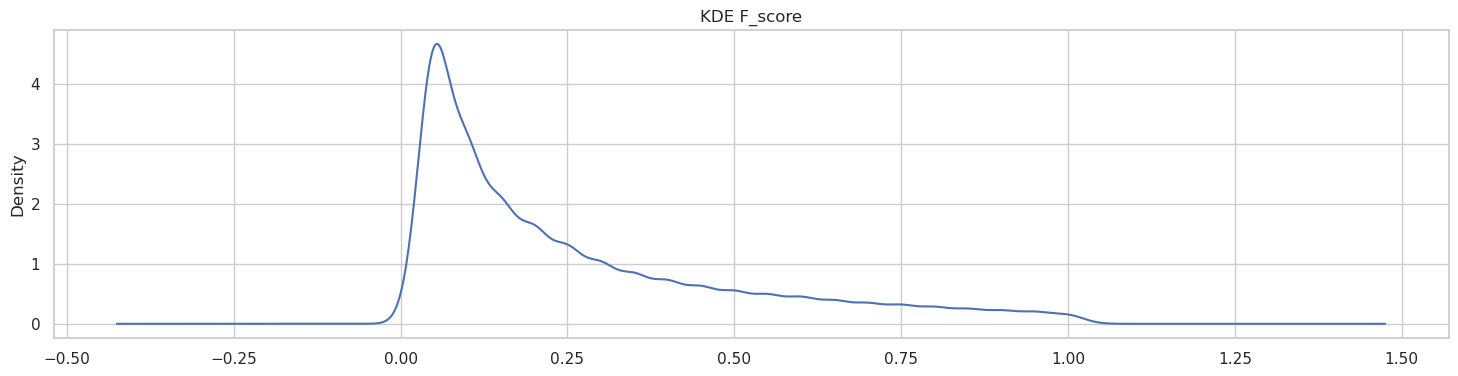

In [555]:
rfm_transformado['F_score'].plot( kind='kde',label = 'F_score', figsize=(18,4))
plt.title('KDE F_score')
plt.show()

In [556]:
rfm_transformado.isna().sum()

ClienteID          0
PrimerDiaDelMes    0
M                  0
F                  0
R                  0
Mes                0
R_score            0
F_score            0
M_score            0
Mes escalado       0
dtype: int64

In [557]:
rfm_transformado.shape

(98064, 10)

In [558]:
import seaborn as sns

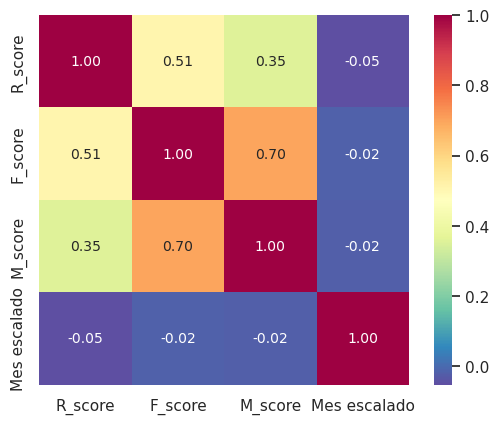

In [559]:
dff = rfm_transformado[["R_score","F_score","M_score",'Mes escalado']]
corrmat = dff.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10},
                 yticklabels=dff.columns, 
                 xticklabels=dff.columns, 
                 cmap="Spectral_r")
plt.style.use('ggplot')

plt.show()

# Segmentación 

In [560]:
variables_numericas = rfm_transformado.iloc[:,6:9]

In [561]:
variables_numericas.head()

,R_score,F_score,M_score
0,0.677419,0.10,0.017306
1,0.322581,0.05,0.005732
2,0.483871,0.05,0.016407
3,0.838710,0.20,0.068367
4,0.225806,0.05,0.017815


In [562]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [740]:
def find_optimal_clusters(data, k_values, estimator):
    silhouette_scores = []
    inertia_values = []

    for k in k_values:

        if isinstance(estimator, (KMeans, AgglomerativeClustering)):
            estimator.set_params(n_clusters=k)
        elif isinstance(estimator, GaussianMixture):
            estimator.set_params(n_components=k)

        estimator.fit(data)

        if isinstance(estimator, AgglomerativeClustering):
            labels = estimator.labels_
        else:
            labels = estimator.predict(data)

        score = silhouette_score(data, labels)
        silhouette_scores.append(score)

        if isinstance(estimator, KMeans):
            inertia_values.append(estimator.inertia_)

    optimal_clusters = k_values[np.argmax(silhouette_scores)]
   
    
       # Ajustar el modelo con el número óptimo de clústers
    if isinstance(estimator, (KMeans, AgglomerativeClustering)):
        estimator.set_params(n_clusters=optimal_clusters)
    elif isinstance(estimator, GaussianMixture):
        estimator.set_params(n_components=optimal_clusters)

    estimator.fit(data)

    if isinstance(estimator, AgglomerativeClustering):
        best_labels = estimator.labels_
    else:
        best_labels = estimator.predict(data)
    
    data['cluster'] = best_labels
    
    
    # Calcular los centroides de los clústers si se utiliza K-Means
    if isinstance(estimator, KMeans):
        centroids = estimator.cluster_centers_
        print("Coordenadas de los centroides:")
        print(centroids)


  
    print(f"Número óptimo de clústers: {optimal_clusters}")
    
    #cm = plt.cm.RdBu
    #cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    R = data.iloc[:, 0]
    F = data.iloc[:, 1]
    M = data.iloc[:, 2]
    c = best_labels  # Utilizar las etiquetas del mejor ajus
    ax.scatter(R, F, M, c=c)
    ax.set_xlabel('R_score')
    ax.set_ylabel('F_score')
    ax.set_zlabel('M_score')

    plt.show()



    print(f'Los coeficientes de silueta de clústers según el número de clústers son:{silhouette_scores}')

    # Graficar el parámetro inertia_ solo para K-means
    if isinstance(estimator, KMeans):
        plt.plot(k_values, inertia_values, 'bx-')
        plt.xlabel('Número de clusters (k)')
        plt.ylabel('Inercia')
        plt.title('Método del codo: Curva de la suma de las distancias cuadradas intra-cluster')
        plt.show()

    # Graficar la curva de silueta para todos los estimadores
    plt.plot(k_values, silhouette_scores, 'bx-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Coeficiente de silueta')
    plt.title('Coeficiente de silueta en función del número de clusters')
    plt.show()
    

    return  data, silhouette_scores, optimal_clusters


In [564]:
estimator1 = KMeans(n_init='auto')
k_values = range(2, 11)

Número óptimo de clústers: 3


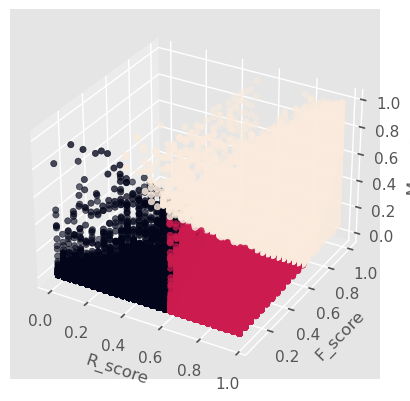

Los coeficientes de silueta de clústers según el número de clústers son:[0.4736243446050897, 0.4791317424621577, 0.3764851717802835, 0.39624789287640216, 0.38848817062565855, 0.38739093727375706, 0.3499102094059088, 0.3324225533966313, 0.3716747717847017]


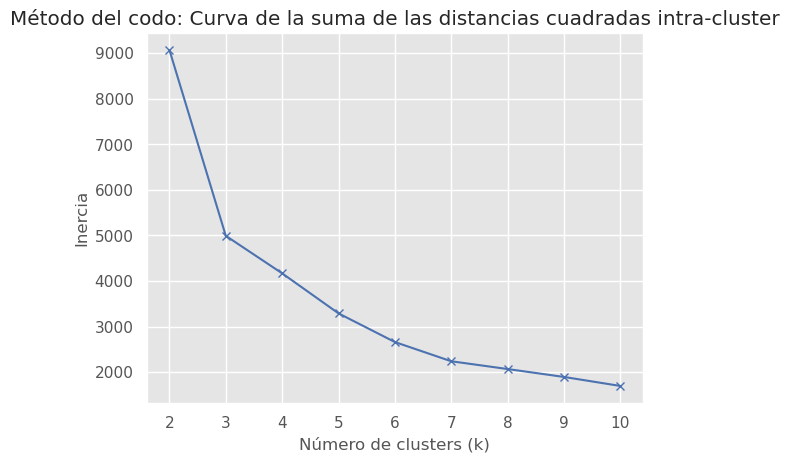

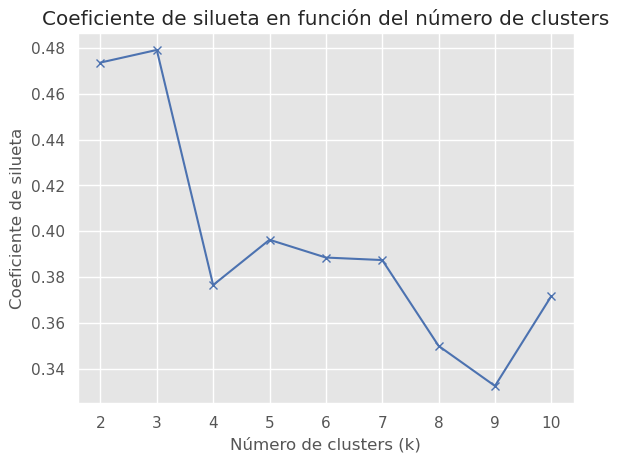

In [565]:
data, silhouette_scores1, optimal_clusters1 = find_optimal_clusters(variables_numericas, k_values, estimator1)

In [566]:
data['cluster'].unique()

array([1, 0, 2], dtype=int32)

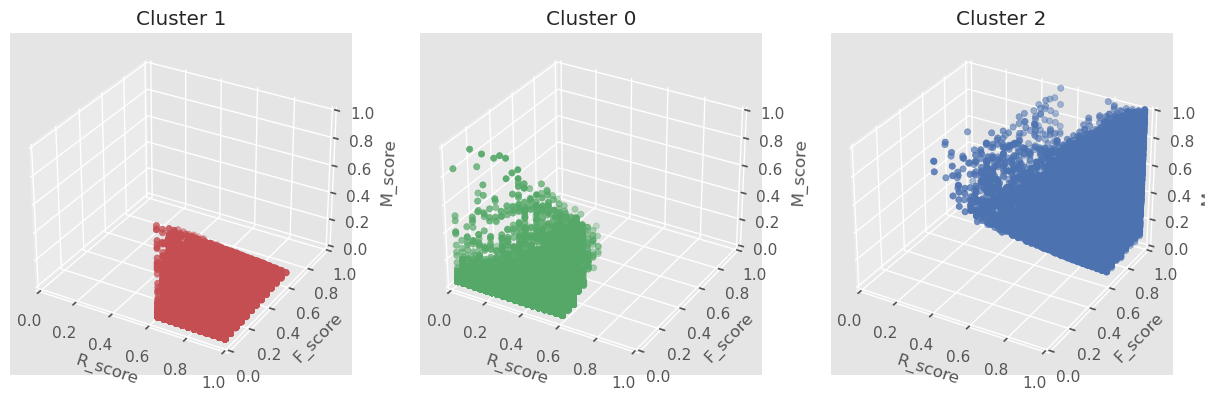

In [567]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Supongamos que 'data' ya contiene la columna 'cluster'

# Obtenemos los valores únicos de 'cluster' en el DataFrame
unique_clusters = data['cluster'].unique()

# Definir una lista de colores
colors = ['r', 'g', 'b']  # Por ejemplo, rojo, verde, azul

# Crear una figura y subplots para las 3 gráficas
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

for i, cluster_id in enumerate(unique_clusters):
    # Filtrar el DataFrame para obtener los datos del clúster actual
    cluster_data = data[data['cluster'] == cluster_id]

    R = cluster_data['R_score']
    F = cluster_data['F_score']
    M = cluster_data['M_score']

    axs[i].scatter(R, F, M, c=colors[i], label=f'Cluster {cluster_id}')
    axs[i].set_xlabel('R_score')
    axs[i].set_ylabel('F_score')
    axs[i].set_zlabel('M_score')
    axs[i].set_title(f'Cluster {cluster_id}')
  
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].set_zlim(0, 1)

plt.show()


In [568]:
k_values = range(4, 5)

Número óptimo de clústers: 4


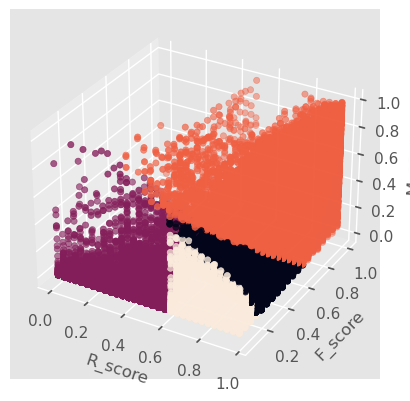

Los coeficientes de silueta de clústers según el número de clústers son:[0.5470964201850119]


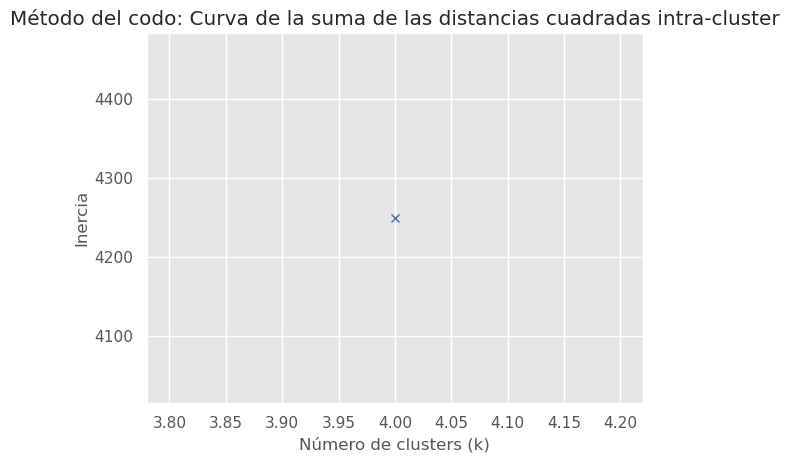

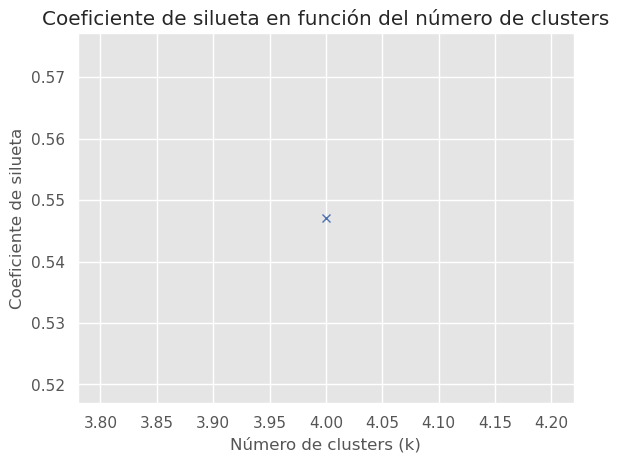

In [569]:
data, silhouette_scores1, optimal_clusters1 = find_optimal_clusters(variables_numericas, k_values, estimator1)

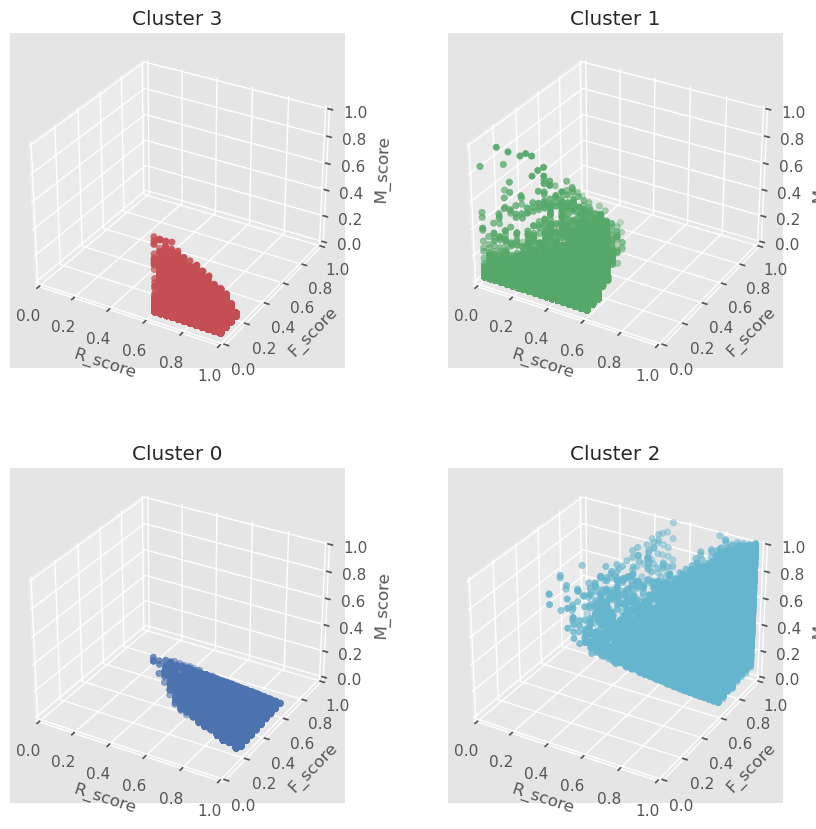

In [570]:
# Obtenemos los valores únicos de 'cluster' en el DataFrame
unique_clusters = data['cluster'].unique()

# Definir una lista de colores
colors = ['r', 'g', 'b', 'c']  # Colores para 4 clústers

# Crear una figura y subplots para las 4 gráficas
fig, axs = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})

for i, cluster_id in enumerate(unique_clusters[:4]):  # Tomamos solo los primeros 4 clústers
    # Filtrar el DataFrame para obtener los datos del clúster actual
    cluster_data = data[data['cluster'] == cluster_id]

    R = cluster_data['R_score']
    F = cluster_data['F_score']
    M = cluster_data['M_score']

    # Calcular las coordenadas en axs
    row, col = divmod(i, 2)
    
    axs[row, col].scatter(R, F, M, c=colors[i], label=f'Cluster {cluster_id}')
    axs[row, col].set_xlabel('R_score')
    axs[row, col].set_ylabel('F_score')
    axs[row, col].set_zlabel('M_score')
    axs[row, col].set_title(f'Cluster {cluster_id}')
    
    axs[row, col].set_xlim(0, 1)
    axs[row, col].set_ylim(0, 1)
    axs[row, col].set_zlim(0, 1)

# Ajustar el espaciado entre subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()


In [571]:
k_values = range(5, 6)

Número óptimo de clústers: 5


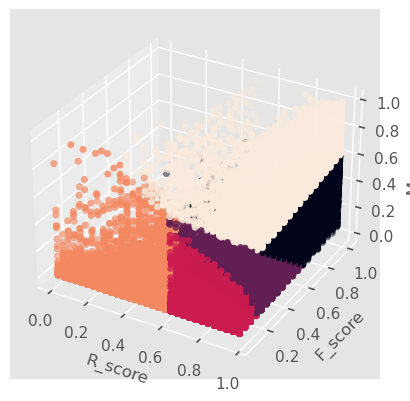

Los coeficientes de silueta de clústers según el número de clústers son:[0.7263970450436836]


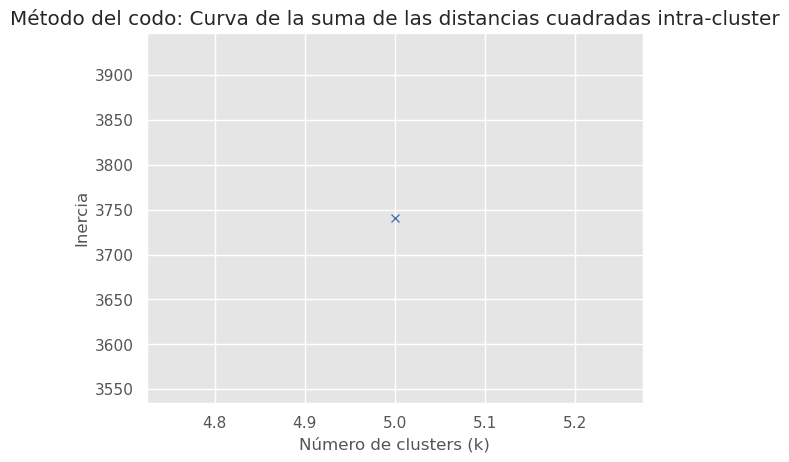

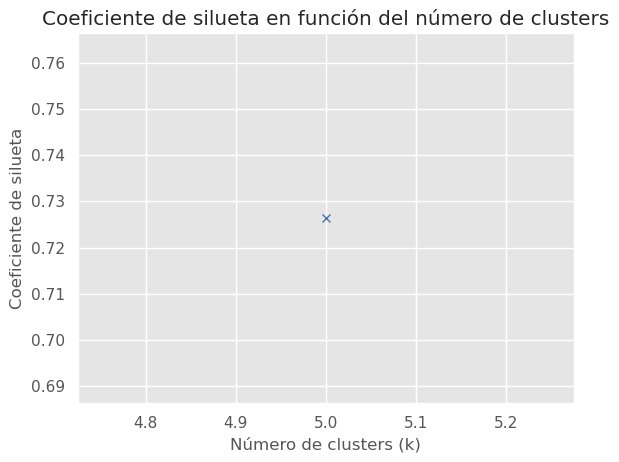

In [572]:
data, silhouette_scores1, optimal_clusters1 = find_optimal_clusters(variables_numericas, k_values, estimator1)

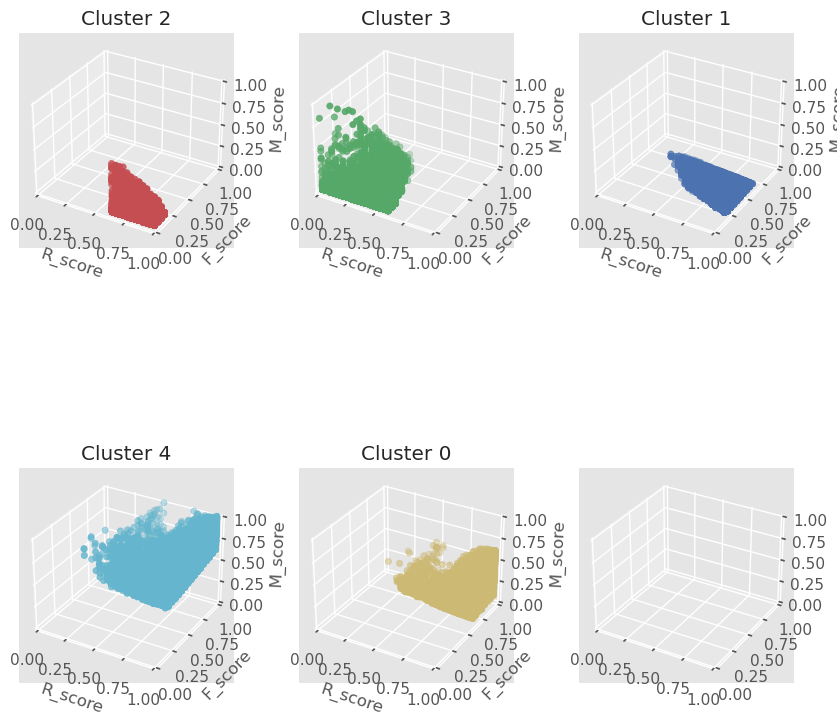

In [573]:


# Obtenemos los valores únicos de 'cluster' en el DataFrame
unique_clusters = data['cluster'].unique()

# Definir una lista de colores
colors = ['r', 'g', 'b', 'c','y']  # Colores para 4 clústers

# Crear una figura y subplots para las 4 gráficas
fig, axs = plt.subplots(2, 3, figsize=(10, 10), subplot_kw={'projection': '3d'})

for i, cluster_id in enumerate(unique_clusters[:5]):  # Tomamos solo los primeros 4 clústers
    # Filtrar el DataFrame para obtener los datos del clúster actual
    cluster_data = data[data['cluster'] == cluster_id]

    R = cluster_data['R_score']
    F = cluster_data['F_score']
    M = cluster_data['M_score']

    # Calcular las coordenadas en axs
    row, col = divmod(i, 3)
    
    axs[row, col].scatter(R, F, M, c=colors[i], label=f'Cluster {cluster_id}')
    axs[row, col].set_xlabel('R_score')
    axs[row, col].set_ylabel('F_score')
    axs[row, col].set_zlabel('M_score')
    axs[row, col].set_title(f'Cluster {cluster_id}')
    
    axs[row, col].set_xlim(0, 1)
    axs[row, col].set_ylim(0, 1)
    axs[row, col].set_zlim(0, 1)

# Ajustar el espaciado entre subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()


In [574]:
k_values = range(6, 7)

Número óptimo de clústers: 6


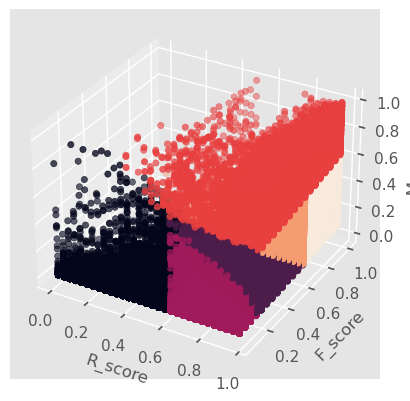

Los coeficientes de silueta de clústers según el número de clústers son:[0.7562727037395364]


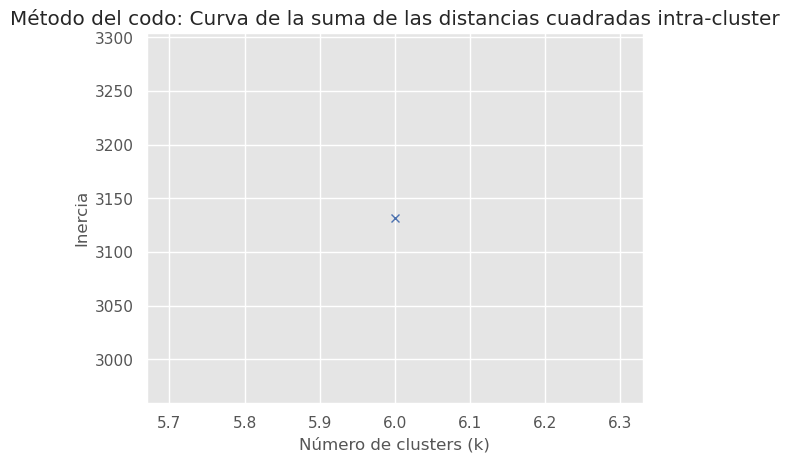

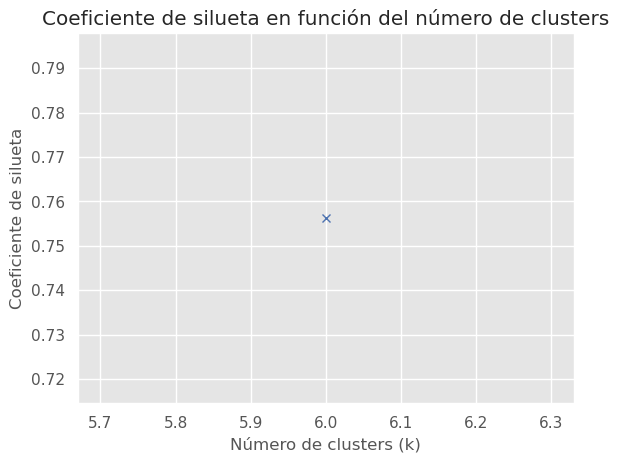

In [575]:
data, silhouette_scores1, optimal_clusters1 = find_optimal_clusters(variables_numericas, k_values, estimator1)

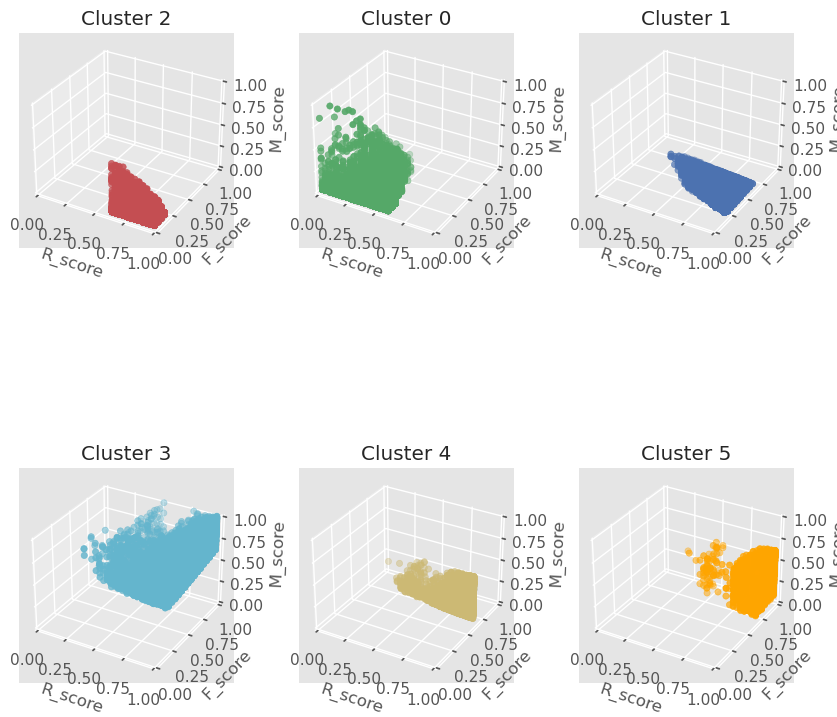

In [576]:


# Obtenemos los valores únicos de 'cluster' en el DataFrame
unique_clusters = data['cluster'].unique()

# Definir una lista de colores
colors = ['r', 'g', 'b', 'c','y','orange']  # Colores para 6 clústers

# Crear una figura y subplots para las 4 gráficas
fig, axs = plt.subplots(2, 3, figsize=(10, 10), subplot_kw={'projection': '3d'})

for i, cluster_id in enumerate(unique_clusters):  # Tomamos solo los primeros 4 clústers
    # Filtrar el DataFrame para obtener los datos del clúster actual
    cluster_data = data[data['cluster'] == cluster_id]

    R = cluster_data['R_score']
    F = cluster_data['F_score']
    M = cluster_data['M_score']

    # Calcular las coordenadas en axs
    row, col = divmod(i, 3)
    
    axs[row, col].scatter(R, F, M, c=colors[i], label=f'Cluster {cluster_id}')
    axs[row, col].set_xlabel('R_score')
    axs[row, col].set_ylabel('F_score')
    axs[row, col].set_zlabel('M_score')
    axs[row, col].set_title(f'Cluster {cluster_id}')
    
    axs[row, col].set_xlim(0, 1)
    axs[row, col].set_ylim(0, 1)
    axs[row, col].set_zlim(0, 1)

# Ajustar el espaciado entre subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()


Coordenadas de los centroides:
[[8.02548982e-01 1.18532163e-01 3.59250372e-02 3.00000000e+00]
 [8.85983334e-01 3.32093320e-01 1.32198483e-01 3.99680289e-14]
 [8.53225465e-01 3.88253331e-01 6.89790387e-01 6.00000000e+00]
 [4.67808329e-01 9.82162201e-02 4.17833776e-02 4.00000000e+00]
 [1.81673834e-01 6.29818751e-02 2.33448622e-02 2.00000000e+00]
 [9.08486352e-01 6.60098291e-01 3.32054111e-01 1.00000000e+00]
 [9.16424404e-01 7.75345432e-01 7.68960791e-01 5.00000000e+00]]
Número óptimo de clústers: 7


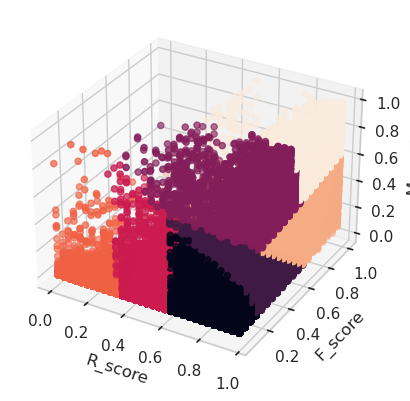

Los coeficientes de silueta de clústers según el número de clústers son:[0.8242692357468446]


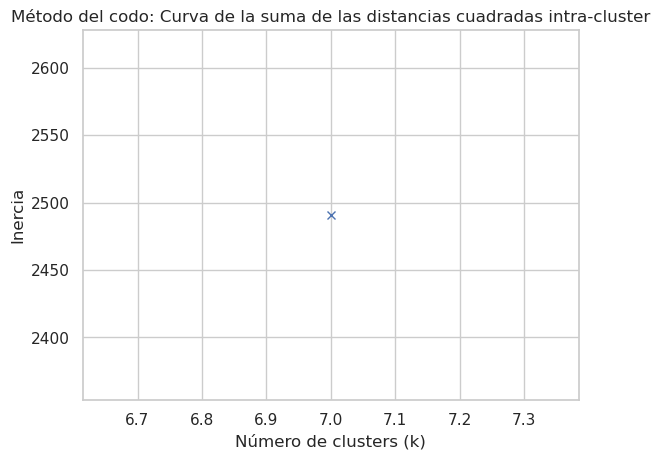

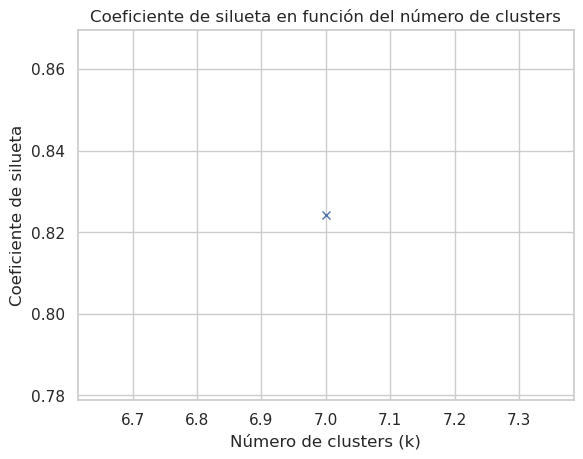

In [741]:
k_values = range(7, 8)
data, silhouette_scores1, optimal_clusters1 = find_optimal_clusters(variables_numericas, k_values, estimator1)

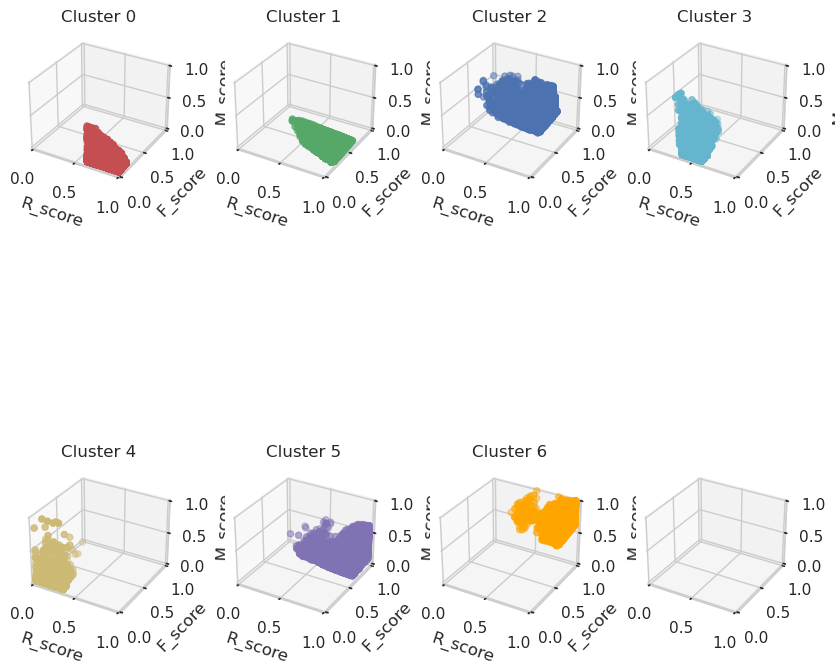

In [742]:
# Obtenemos los valores únicos de 'cluster' en el DataFrame
unique_clusters = np.sort(data['cluster'].unique())

# Definir una lista de colores
colors = ['r', 'g', 'b', 'c','y','m','orange']  # Colores para 6 clústers

# Crear una figura y subplots para las 4 gráficas
fig, axs = plt.subplots(2, 4, figsize=(10, 10), subplot_kw={'projection': '3d'})

for i, cluster_id in enumerate(unique_clusters):  # Tomamos solo los primeros 4 clústers
    # Filtrar el DataFrame para obtener los datos del clúster actual
    cluster_data = data[data['cluster'] == cluster_id]

    R = cluster_data['R_score']
    F = cluster_data['F_score']
    M = cluster_data['M_score']

    # Calcular las coordenadas en axs
    row, col = divmod(i, 4)
    
    axs[row, col].scatter(R, F, M, c=colors[i], label=f'Cluster {cluster_id}')
    axs[row, col].set_xlabel('R_score')
    axs[row, col].set_ylabel('F_score')
    axs[row, col].set_zlabel('M_score')
    axs[row, col].set_title(f'Cluster {cluster_id}')
    
    axs[row, col].set_xlim(0, 1)
    axs[row, col].set_ylim(0, 1)
    axs[row, col].set_zlim(0, 1)

# Ajustar el espaciado entre subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()


In [598]:
rfm_transformado['cluster'] = data['cluster']

In [599]:
rfm_transformado.head()

,ClienteID,PrimerDiaDelMes,M,F,R,Mes,R_score,F_score,M_score,Mes escalado,cluster
0,1000026,2020-08-01,69320.00,2.0,10,8,0.677419,0.10,0.017306,0.666667,3
1,1000026,2020-09-01,22959.86,1.0,21,9,0.322581,0.05,0.005732,0.750000,2
2,1000026,2020-10-01,65720.00,1.0,16,10,0.483871,0.05,0.016407,0.833333,4
3,1000026,2020-11-01,273843.71,4.0,5,11,0.838710,0.20,0.068367,0.916667,3
4,1000026,2020-12-01,71360.00,1.0,24,12,0.225806,0.05,0.017815,1.000000,2


# Cálculo de la columna Churn

In [600]:
rfm_final = rfm_transformado.copy()

In [601]:
rfm_final.head()

,ClienteID,PrimerDiaDelMes,M,F,R,Mes,R_score,F_score,M_score,Mes escalado,cluster
0,1000026,2020-08-01,69320.00,2.0,10,8,0.677419,0.10,0.017306,0.666667,3
1,1000026,2020-09-01,22959.86,1.0,21,9,0.322581,0.05,0.005732,0.750000,2
2,1000026,2020-10-01,65720.00,1.0,16,10,0.483871,0.05,0.016407,0.833333,4
3,1000026,2020-11-01,273843.71,4.0,5,11,0.838710,0.20,0.068367,0.916667,3
4,1000026,2020-12-01,71360.00,1.0,24,12,0.225806,0.05,0.017815,1.000000,2


In [602]:
wf=0.333
wm=0.333
wr=0.333

In [603]:
rfm_final['RFM'] = rfm_final['R_score']*wr + rfm_final['F_score']*wf + rfm_final['M_score']*wm

In [604]:
rfm_final.head()

,ClienteID,PrimerDiaDelMes,M,F,R,Mes,R_score,F_score,M_score,Mes escalado,cluster,RFM
0,1000026,2020-08-01,69320.00,2.0,10,8,0.677419,0.10,0.017306,0.666667,3,0.264644
1,1000026,2020-09-01,22959.86,1.0,21,9,0.322581,0.05,0.005732,0.750000,2,0.125978
2,1000026,2020-10-01,65720.00,1.0,16,10,0.483871,0.05,0.016407,0.833333,4,0.183243
3,1000026,2020-11-01,273843.71,4.0,5,11,0.838710,0.20,0.068367,0.916667,3,0.368656
4,1000026,2020-12-01,71360.00,1.0,24,12,0.225806,0.05,0.017815,1.000000,2,0.097776


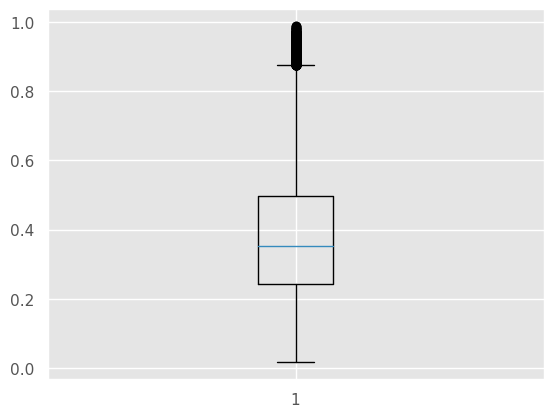

In [605]:
plt.boxplot(rfm_final['RFM'])
plt.show()

In [606]:
np.percentile(rfm_final['RFM'], 25)

0.24277254851846833

In [610]:
rfm_final['churn'] = rfm_final['RFM'].apply(lambda x: 1 if x > 0.2427 else 0)

In [611]:
rfm_final['churn'].value_counts()

churn
1    73555
0    24509
Name: count, dtype: int64

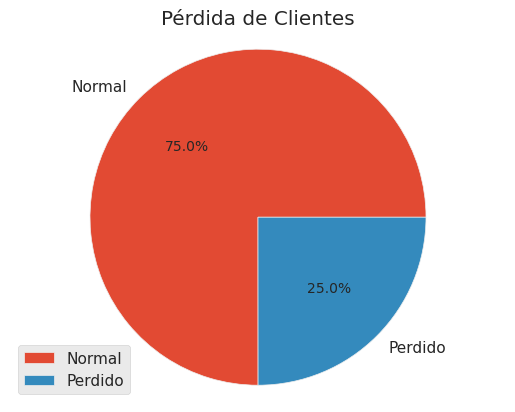

In [612]:
sizes = rfm_final['churn'].value_counts()
title = "Pérdida de Clientes"
labels=["Normal","Perdido"]
fi1,ax1=plt.subplots()
ax1.pie(sizes, labels=labels,autopct='%1.1f%%')
ax1.axis('equal')
plt.legend(loc='lower left')
plt.title(title)
plt.show()

In [613]:
rfm_final.head()

,ClienteID,PrimerDiaDelMes,M,F,R,Mes,R_score,F_score,M_score,Mes escalado,cluster,RFM,churn
0,1000026,2020-08-01,69320.00,2.0,10,8,0.677419,0.10,0.017306,0.666667,3,0.264644,1
1,1000026,2020-09-01,22959.86,1.0,21,9,0.322581,0.05,0.005732,0.750000,2,0.125978,0
2,1000026,2020-10-01,65720.00,1.0,16,10,0.483871,0.05,0.016407,0.833333,4,0.183243,0
3,1000026,2020-11-01,273843.71,4.0,5,11,0.838710,0.20,0.068367,0.916667,3,0.368656,1
4,1000026,2020-12-01,71360.00,1.0,24,12,0.225806,0.05,0.017815,1.000000,2,0.097776,0


Pasamos la variable objetivo como la primera columna porque así lo pide Sage Maker

In [614]:
cols = rfm_final.columns.tolist()
cols = cols[-1:] + cols[:-1]
rfm_final = rfm_final[cols]

In [615]:
rfm_final.head()

,churn,ClienteID,PrimerDiaDelMes,M,F,R,Mes,R_score,F_score,M_score,Mes escalado,cluster,RFM
0,1,1000026,2020-08-01,69320.00,2.0,10,8,0.677419,0.10,0.017306,0.666667,3,0.264644
1,0,1000026,2020-09-01,22959.86,1.0,21,9,0.322581,0.05,0.005732,0.750000,2,0.125978
2,0,1000026,2020-10-01,65720.00,1.0,16,10,0.483871,0.05,0.016407,0.833333,4,0.183243
3,1,1000026,2020-11-01,273843.71,4.0,5,11,0.838710,0.20,0.068367,0.916667,3,0.368656
4,0,1000026,2020-12-01,71360.00,1.0,24,12,0.225806,0.05,0.017815,1.000000,2,0.097776


# Entrenamiento

In [616]:
df_entreno = rfm_final[['churn','ClienteID','Mes escalado','R_score','F_score','M_score','PrimerDiaDelMes']]

In [617]:
df_entreno.dtypes

churn                       int64
ClienteID                   int64
Mes escalado              float64
R_score                   float64
F_score                   float64
M_score                   float64
PrimerDiaDelMes    datetime64[ns]
dtype: object

In [618]:
df_entreno.head()

,churn,ClienteID,Mes escalado,R_score,F_score,M_score,PrimerDiaDelMes
0,1,1000026,0.666667,0.677419,0.10,0.017306,2020-08-01
1,0,1000026,0.750000,0.322581,0.05,0.005732,2020-09-01
2,0,1000026,0.833333,0.483871,0.05,0.016407,2020-10-01
3,1,1000026,0.916667,0.838710,0.20,0.068367,2020-11-01
4,0,1000026,1.000000,0.225806,0.05,0.017815,2020-12-01


## Partición de los datos

Normalmente se particionarían los datos con train-test-split de Scikit-learn pero vamos a dividr los datos manualmente, separando el 20% para la prueba y la validación, o los últimos 6 meses. 

In [619]:
df_entreno['PrimerDiaDelMes'].nunique()

32

Observamos que tenemos una población con 32 meses diferentes. Para extraer los datos de test y validación que serán el 20% de los meses, se escogen los últimos 7 meses. 

In [620]:
#from sklearn.model_selection import train_test_split
#train, test_and_validate = train_test_split(df_entreno, test_size=0.2, random_state=42, stratify=rfm_final['churn'])

In [621]:
filtro = df_entreno['PrimerDiaDelMes']>'2022-01-31'

In [622]:
test_and_validate=df_entreno[filtro]

In [623]:
test_and_validate['PrimerDiaDelMes'].nunique()

7

In [624]:
validate = df_entreno[(df_entreno['PrimerDiaDelMes'] >'2022-01-31') & (df_entreno['PrimerDiaDelMes'] <= '2022-05-31')]

In [625]:
validate['PrimerDiaDelMes'].value_counts()

PrimerDiaDelMes
2022-05-01    3673
2022-04-01    3623
2022-03-01    3615
2022-02-01    3585
Name: count, dtype: int64

In [626]:
test = df_entreno[df_entreno['PrimerDiaDelMes'] >'2022-05-31']

In [627]:
test['PrimerDiaDelMes'].value_counts()

PrimerDiaDelMes
2022-07-01    3563
2022-06-01    3550
2022-08-01    3314
Name: count, dtype: int64

In [628]:
train= df_entreno[df_entreno['PrimerDiaDelMes'] <='2022-01-31']

In [629]:
train['PrimerDiaDelMes'].nunique()

25

In [630]:
test = test.drop('PrimerDiaDelMes',axis=1)
train = train.drop('PrimerDiaDelMes',axis=1)
validate= validate.drop('PrimerDiaDelMes',axis=1)

In [631]:
print(train.shape)
print(test.shape)
print(validate.shape)

(73141, 6)
(10427, 6)
(14496, 6)


In [632]:
print(train['churn'].value_counts())
print(test['churn'].value_counts())
print(validate['churn'].value_counts())

churn
1    56306
0    16835
Name: count, dtype: int64
churn
1    6444
0    3983
Name: count, dtype: int64
churn
1    10805
0     3691
Name: count, dtype: int64


## Carga de Amazon S3

In [633]:
import boto3
import io
import sagemaker

In [634]:
bucket='sagemaker-eu-west-3-336090548075'

train_file='train_out_of_time.csv'
test_file='test_out_of_time.csv'
validate_file='validate_out_of_time.csv'

import os

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(folder, filename)).put(Body=csv_buffer.getvalue())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [635]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

# Entrenar el modelo 

In [636]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.7-1')

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [637]:
hyperparams={"eval_metric": "auc",
             "objective": "binary:logistic",
             "max_depth":"5",
             "eta":"0.2",
             "gamma":"4",
             "min_child_weight":"10",
             "subsample":"0.7",
             "num_round":"30"
            }

In [638]:
s3_output_location = "s3://{}/output/".format(bucket)

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

In [639]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator
save_interval = 5
s3_output_path="s3://{}/shap".format(bucket)
feature_names = list(train.iloc[:,1:].columns)

In [640]:
feature_names

['ClienteID', 'Mes escalado', 'R_score', 'F_score', 'M_score']

In [641]:
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=2,
                                       instance_type='ml.c5.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session(),
                                        debugger_hook_config=DebuggerHookConfig(
                                            s3_output_path=s3_output_path,  # Required
                                                collection_configs=[
                                                    CollectionConfig(
                                                        name="metrics", 
                                                        parameters={
                                                            "save_interval": str(save_interval)
                                                        }),
                                                    CollectionConfig(
                                                        name="feature_importance",
                                                        parameters={"save_interval": str(save_interval)
                                                        }),
                                                    CollectionConfig(
                                                        name="full_shap", 
                                                        parameters={"save_interval": str(save_interval)
                                                        }),
                                                    CollectionConfig(
                                                        name="average_shap", 
                                                        parameters={"save_interval": str(save_interval)
                                                        }),
                                                ],
                                        ),
                                        rules=[
                                            Rule.sagemaker(
                                                rule_configs.loss_not_decreasing(),
                                                rule_parameters={
                                                    "collection_names": "metrics",
                                                    "num_steps": str(save_interval * 2),
                                                },
                                            ),
                                        ],
                                        
                                       )

In [642]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/train/".format(bucket,train_file),
    distribution='ShardedByS3Key',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/validate/".format(bucket,validate_file),
      distribution='ShardedByS3Key',
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [643]:
xgb_model.fit(inputs=data_channels, logs=True)
print('¡Listo!')

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-10-16-10-06-21-155


2023-10-16 10:06:21 Starting - Starting the training job...
2023-10-16 10:06:49 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
.........
2023-10-16 10:08:17 Downloading - Downloading input data...
2023-10-16 10:08:46 Training - Downloading the training image..[2023-10-16 10:09:01.712 ip-10-0-169-152.eu-west-3.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-10-16 10:09:01.747 ip-10-0-169-152.eu-west-3.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-10-16:10:09:02:INFO] Imported framework sagemaker_xgboost_container.training
[2023-10-16:10:09:02:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2023-10-16:10:09:02:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2023-10-16:10:09:02:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-16:10:09:02:INFO] Running XGBoost Sagemaker 

In [644]:
import time

for _ in range(36):
    job_name = xgb_model.latest_training_job.name
    client = xgb_model.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgb_model.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )

    if training_job_status in ["Completed", "Failed"]:
        break

    time.sleep(10)

Training job status: Completed, Rule Evaluation Status: InProgress


In [645]:
xgb_model.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:eu-west-3:336090548075:processing-job/sagemaker-xgboost-2023-10--LossNotDecreasing-08e2ccb2',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2023, 10, 16, 10, 9, 58, 72000, tzinfo=tzlocal())}]

# Interpretación del modelo 

In [646]:
from smdebug.trials import create_trial

In [647]:
s3_output_path = xgb_model.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2023-10-16 10:10:04.152 ip-172-16-20-181.eu-west-3.compute.internal:13506 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-eu-west-3-336090548075/shap/sagemaker-xgboost-2023-10-16-10-06-21-155/debug-output


In [648]:
trial.tensor_names()

['average_shap/f0',
 'average_shap/f1',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f3',
 'feature_importance/total_cover/f4',
 'feature_importance/total_gain/f2',
 'feature_importance/total_gain/f3',
 'feature_importance/total_gain/f4',
 'feature_importance/weight/f2',
 'feature_importance/weight/f3',
 'feature_importance/weight/f4',
 'full_shap/f0',
 'full_shap/f1',
 'full_shap/f2',
 'full_shap/f3',
 'full_shap/f4',
 'train-auc',
 'validation-auc']

In [649]:
trial.tensor("average_shap/f1").values()

{0: array([0.], dtype=float32),
 5: array([0.], dtype=float32),
 10: array([0.], dtype=float32),
 15: array([0.], dtype=float32),
 20: array([0.], dtype=float32),
 25: array([0.], dtype=float32)}

In [650]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

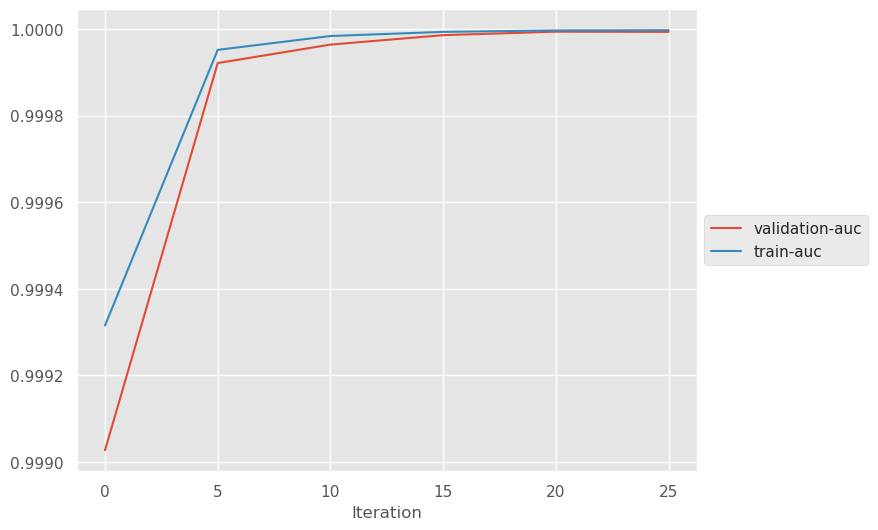

In [651]:
plot_collection(trial, "metrics")

In [652]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = [
        "weight",
        "gain",
        "cover",
        "total_gain",
        "total_cover",
    ]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

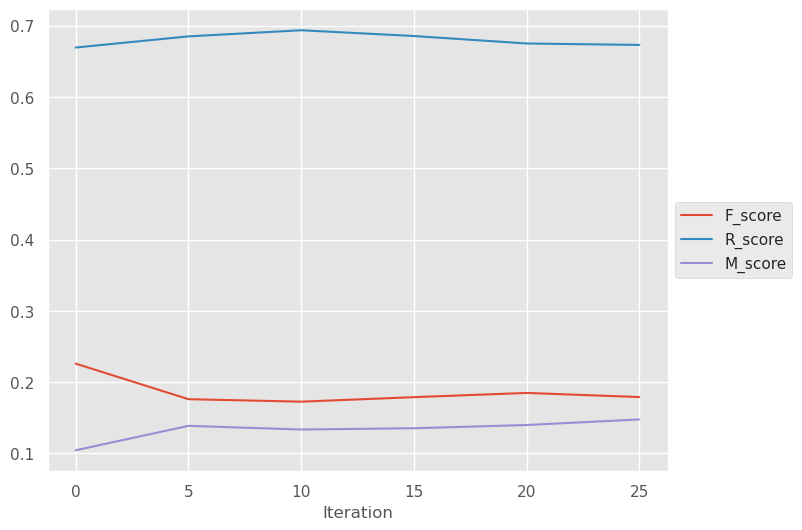

In [653]:
plot_feature_importance(trial, importance_type="cover")

SHAP (SHapley Additive exPlanations) is another approach to explain the output of machine learning models. SHAP values represent a feature’s contribution to a change in the model output. You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by xgboost.predict(pred_contribs=True)) will be available the average_shap collection.

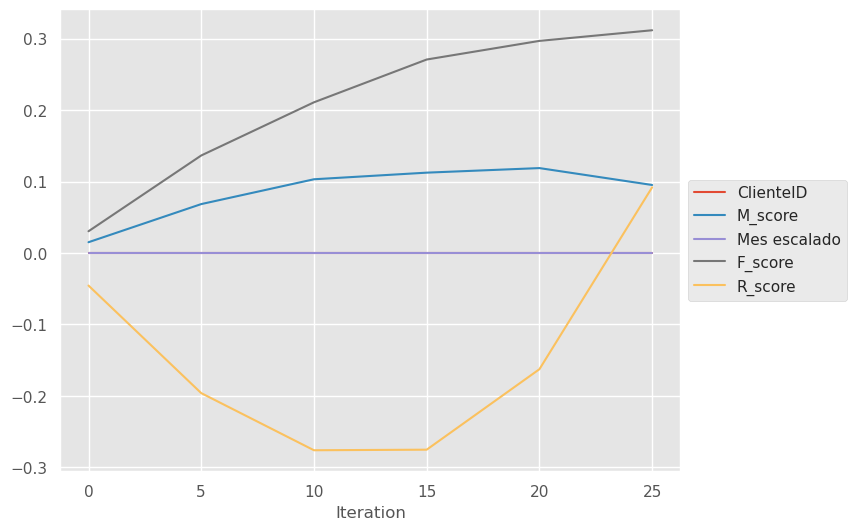

In [654]:
plot_collection(trial, "average_shap")

#### Global explanations

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature.

Specifically, the below plot indicates that the value of relationship

In [655]:
import shap

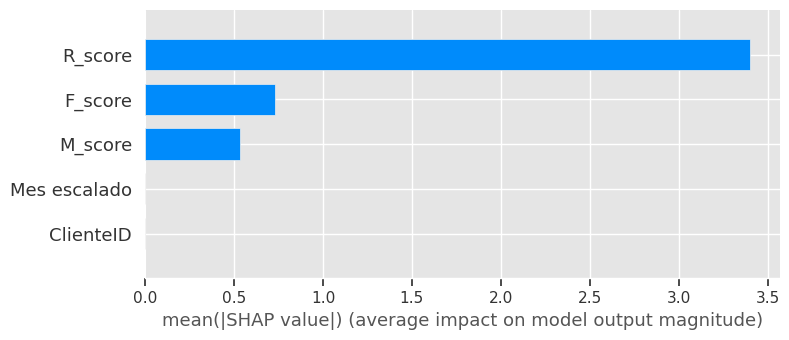

In [656]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction.

The ‘red’ indicates higher value of the feature and ‘blue’ indicates lower (normalized over the features). This allows conclusions such as ‘increase in age leads to higher log odds for prediction, eventually leading to True predictions more often.

In [657]:
shap_base_value

2.7463288

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


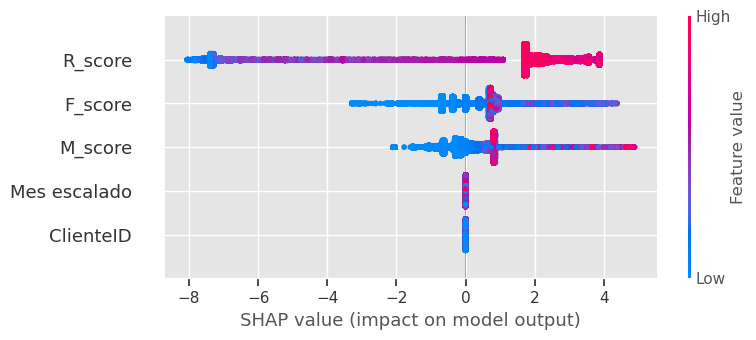

In [658]:
shap.summary_plot(shap_no_base,train.iloc[:,1:])

In [659]:
shap.initjs()

In [660]:
train.iloc[1000,0:1],

(churn    1.0
 Name: 1411, dtype: float64,)

In [661]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train.iloc[100,1:],
    link="logit",
    matplotlib=False,
)

In [662]:
shap.force_plot(
    shap_base_value,
    shap_no_base[1, :],
    train.iloc[1,1:],
    link="logit",
    matplotlib=False,
)

In [663]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [664]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train.iloc[sampled_indices,1:],
    link="logit",
)

#### Outliers

Outliers are extreme values that deviate from other observations on data. It’s useful to understand the influence of various features for outlier predictions to determine if it’s a novelty, an experimental error, or a shortcoming in the model.

Here we show force plot for prediction outliers that are on either side of the baseline value.

In [665]:
# top outliers
from scipy import stats

N_OUTLIERS = 3  # number of outliers on each side of the tail

shap_sum = np.sum(shap_no_base, axis=1)
z_scores = stats.zscore(shap_sum)
outlier_indices = (np.argpartition(z_scores, -N_OUTLIERS)[-N_OUTLIERS:]).tolist()
outlier_indices += (np.argpartition(z_scores, N_OUTLIERS)[:N_OUTLIERS]).tolist()

In [666]:
for fig_index, outlier_index in enumerate(outlier_indices, start=1):
    shap.force_plot(
        shap_base_value,
        shap_no_base[outlier_index, :],
        train.iloc[outlier_index,1:],
        matplotlib=False,
        link="logit",
    )

In [667]:
shap_base_value

2.7463288

## Implementación del código

In [668]:
#from sagemaker.serializers import CSVSerializer

In [669]:
#xgb_predictor = xgb_model.deploy(
#    initial_instance_count=1, instance_type="ml.c5.xlarge", serializer=CSVSerializer()
#)



# Predicciones 

In [670]:
#test.shape

In [671]:
#test.head(5)

In [672]:
#row = test.iloc[3:4,1:]
#row.head()

In [673]:
# convertir esto en un archivo de valores separados por comas (CSV) y almacenarlo en un búfer de cadena.
#batch_X_csv_buffer = io.StringIO()
#row.to_csv(batch_X_csv_buffer, header=False, index=False)
#test_row = batch_X_csv_buffer.getvalue()
#print(test_row)

In [674]:
#xgb_predictor.predict(test_row)

In [675]:
#xgb_predictor.delete_endpoint(delete_endpoint_config=True)

## Transformación por lotes

Cuando se encuentra en el ciclo de diseño de características de entrenamiento-prueba, desea probar sus conjuntos de retención o de pruebas con el modelo. A continuación, puede utilizar esos resultados para calcular métricas. Puede implementar un punto de enlace como lo hizo anteriormente, pero después debe recordar eliminar el punto de enlace. Sin embargo, hay una manera más eficiente.

Puede utilizar el método transformador del modelo para obtener un objeto transformador. A continuación, puede utilizar el método de transformación de este objeto para realizar una predicción en todo el conjunto de datos de prueba. SageMaker: 

- Activará una instancia con el modelo
- Realizará una predicción sobre todos los valores de entrada
- Escribirá esos valores en Amazon Simple Storage Service (Amazon S3) 
Por último, finalizará la instancia

Comenzará convirtiendo sus datos en un archivo CSV que el objeto transformador puede tomar como entrada. Esta vez, usará **iloc** para obtener todas las filas y todas las columnas *excepto* la primera columna.


In [676]:
batch_X = test.iloc[:,1:];
batch_X.head()

,ClienteID,Mes escalado,R_score,F_score,M_score
20,1000026,0.500000,0.967742,0.30,0.070787
21,1000026,0.583333,0.935484,0.30,0.115776
51,1000036,0.500000,0.580645,0.35,0.677706
52,1000036,0.583333,0.903226,0.40,0.800763
53,1000036,0.666667,0.354839,0.15,0.300678


A continuación, escriba sus datos en un archivo CSV.

In [677]:
batch_X_file='batch-in_out_of_time.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [678]:
batch_output = "s3://{}/batch-out/".format(bucket)
batch_input = "s3://{}/batch-in/{}".format(bucket,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=8,
                                       instance_type='ml.c5.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-10-16-10-10-13-024
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-10-16-10-10-13-692


..........................[2023-10-16:10:14:33:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-16:10:14:33:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-16:10:14:33:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-10-16 10:14:33 +0000] [19] [INFO] Starting gunicorn 

After the transform completes, you can download the results from Amazon S3 and compare them with the input.

First, download the output from Amazon S3 and load it into a pandas DataFrame.


In [679]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="batch-out/{}".format('batch-in_out_of_time.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])
target_predicted.head(5)

,class
0,0.998805
1,0.998805
2,0.996611
3,0.998805
4,0.870274


You can use a function to convert the probabilty into either a *0* or a *1*.

The first table output will be the *predicted values*, and the second table output is the *original test data*.

In [680]:
def binary_convert(x):
    threshold = 0.9

    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
test.head(10)

      class  binary
0  0.998805       1
1  0.998805       1
2  0.996611       1
3  0.998805       1
4  0.870274       0
5  0.998805       1
6  0.998805       1
7  0.667111       0
8  0.939843       1
9  0.998805       1


,churn,ClienteID,Mes escalado,R_score,F_score,M_score
20,1,1000026,0.500000,0.967742,0.30,0.070787
21,1,1000026,0.583333,0.935484,0.30,0.115776
51,1,1000036,0.500000,0.580645,0.35,0.677706
52,1,1000036,0.583333,0.903226,0.40,0.800763
53,1,1000036,0.666667,0.354839,0.15,0.300678
120,1,1000047,0.500000,0.741935,0.25,0.087739
121,1,1000047,0.583333,0.806452,0.10,0.024651
152,0,1002132,0.500000,0.096774,0.05,0.480963
166,1,1002149,0.666667,0.483871,0.05,0.954712
197,1,1002168,0.583333,0.870968,0.40,0.911820


In [681]:
target_predicted_binary = target_predicted['class'].apply(binary_convert)

# Evaluación de métricas

## Matriz de confusión 

Now, you can use the *scikit-learn* library, which contains a function to create a confusion matrix.

In [682]:
test_labels = test.iloc[:,0]
test_labels.head()

20    1
21    1
51    1
52    1
53    1
Name: churn, dtype: int64

In [683]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [684]:
matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix,index=['Perdido','Normal'],columns=['Perdido','Normal'])

df_confusion

,Perdido,Normal
Perdido,3983,0
Normal,269,6175


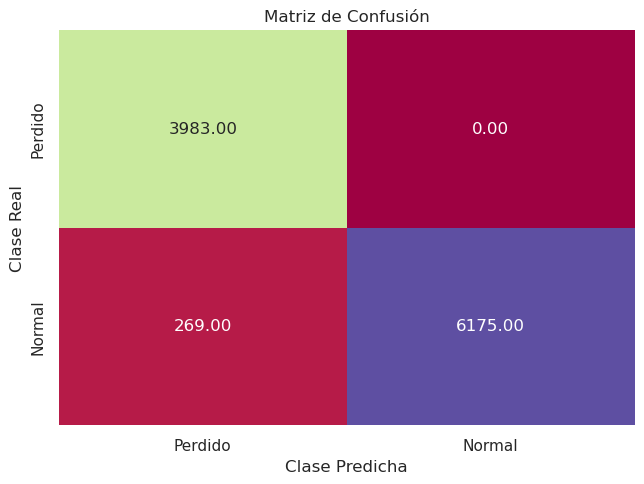

In [685]:
# Configura el formato de los números en notación decimal
sns.set(style="whitegrid")  # Establece el estilo del gráfico
colormap = sns.color_palette("Spectral", as_cmap=True)

# Crea el mapa de calor con formato decimal
sns.heatmap(df_confusion, annot=True, fmt=".2f", cbar=None, cmap=colormap)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.ylabel("Clase Real")
plt.xlabel("Clase Predicha")
plt.show()

In [686]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 3983
False Positive (FP): 0
False Negative (FN): 269
True Positive (TP) : 6175


In [687]:
print(classification_report(test_labels, target_predicted_binary, target_names = ['Perdidos', 'Fieles']))

              precision    recall  f1-score   support

    Perdidos       0.94      1.00      0.97      3983
      Fieles       1.00      0.96      0.98      6444

    accuracy                           0.97     10427
   macro avg       0.97      0.98      0.97     10427
weighted avg       0.98      0.97      0.97     10427



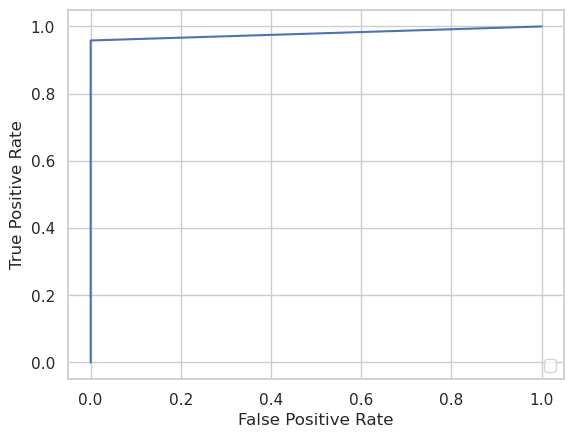

In [688]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(test_labels, target_predicted_binary)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [689]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"Hay una probabilidad de {Sensitivity}% para clasificar cliente fieles que realmente lo son. ")

Sensitivity or TPR: 95.82557417752949%
Hay una probabilidad de 95.82557417752949% para clasificar cliente fieles que realmente lo son. 



### Specificity

The next statistic is *specificity*, which is also known as the *true negative*. It measures the proportion of the actual negatives that are correctly identified.

In this example, the specificity is *the probablity of detecting normal, for patients who are normal*.

In [690]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"Hay una proabilidad de {Specificity}% para predecir clientes perdidos que realmente lo son. ")


Specificity or TNR: 100.0%
Hay una proabilidad de 100.0% para predecir clientes perdidos que realmente lo son. 


### Positive and negative predictive values

The *precision*, or *positive predictive value*, is the proportion of positive results.

In this example, the positive predictive value is *the probability that subjects with a positive screening test truly have an abnormality*.

In [691]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precisión: {Precision}%")

Precisión: 100.0%


The *negative predictive value* is the proportion of negative results.

In this example, the negative predictive value is *the probability that subjects with a negative screening test truly have an abnormality*.

In [692]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 

Negative Predictive Value: 93.67356538099718%


### False positive rate

The *false positive rate (FPR)* is the probability that a false alarm will be raised, or that *a positive result will be given when the true value is negative*. 

In [693]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"There is a {FPR}% chance that this positive result is incorrect.")

There is a 0.0% chance that this positive result is incorrect.


### False negative rate

The *false negative rate* -- or *miss rate* -- is *the probability that a true positive will be missed by the test*.

In [694]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 4.174425822470515%
There is a 4.174425822470515% chance that this negative result is incorrect.


### False discovery rate

In this example, the *false discovery rate* is *the probability of predicting an abnormality when the patient doesn't have one*.

In [695]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 0.0%
You have an abnormality, but there is a 0.0% chance this is incorrect.


### Overall accuracy

How accuracte is your model?

In [696]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 97.42015920207155%


In summary, you calculated the following metrics from your model:

In [697]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 95.82557417752949%
Specificity or TNR: 100.0%
Precision: 100.0%
Negative Predictive Value: 93.67356538099718%
False Positive Rate: 0.0%
False Negative Rate: 4.174425822470515%
False Discovery Rate: 0.0%
Accuracy: 97.42015920207155%


## ROC AUC 

In [698]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score,auc
# calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)

In [699]:
# generamos un modelo sin habilidad para predecir 
ns_probs = [0 for _ in range(len(test_labels))]

In [700]:
len(ns_probs)==len(test_labels)

True

In [701]:
# calculate AUC
auc = roc_auc_score(test_labels, target_predicted_binary)
ns_auc = roc_auc_score(test_labels,ns_probs)
print('XGBoost ROC AUC: %.3f' % auc)
print('No Skill: ROC AUC=%.3f' % (ns_auc))

XGBoost ROC AUC: 0.979
No Skill: ROC AUC=0.500


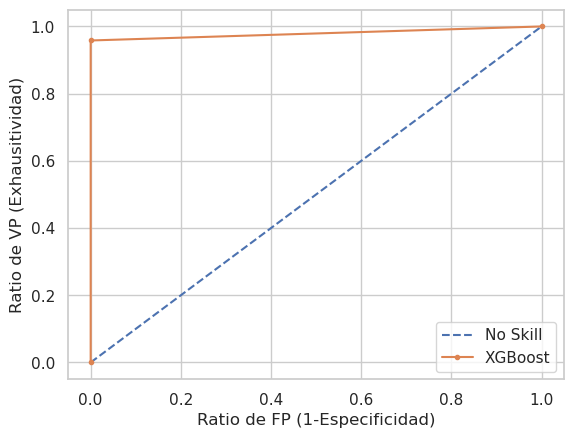

In [702]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
xg_fpr, xg_tpr, _ = roc_curve(test_labels,target_predicted_binary)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xg_fpr, xg_tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('Ratio de FP (1-Especificidad)')
plt.ylabel('Ratio de VP (Exhausitividad)')
# show the legend
plt.legend()
# show the plot
plt.show()

## Precision - Recall 

In [703]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels,target_predicted_binary)

In [704]:
# calculate F1 score
f1_1= f1_score(test_labels,target_predicted_binary)

In [705]:
from sklearn.metrics import auc
# calculate precision-recall AUC
auc_1 = auc(recall, precision)

In [706]:
auc_1

0.9920270748772897

In [707]:
# summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (f1_1, auc_1))

XGBoost: f1=0.979 auc=0.992


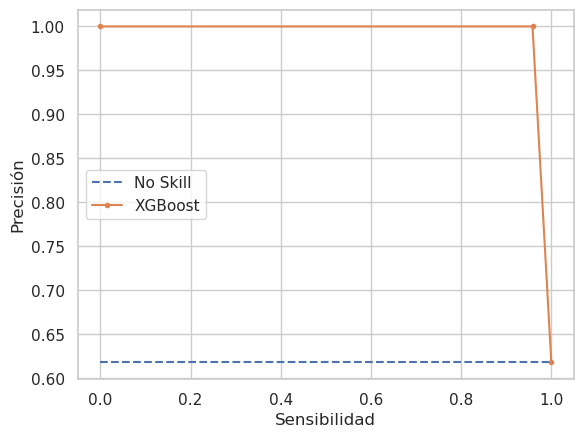

In [708]:
# plot the precision-recall curves
no_skill = len(test_labels[test_labels==1]) / len(test_labels)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall,precision, marker='.', label='XGBoost')
# axis labels
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
# show the legend
plt.legend()
# show the plot
plt.show()

# Creación de un trabajo de ajustes de hiperparámetros

A hyperparameter tuning job can take several hours to complete, depending on the value ranges that you provide. To simplify this task, the parameters used in this step are a subset of the recommended ranges. They were tuned to give good results in this lab, without taking multiple hours to complete.

For more information about the parameters to tune for XGBoost, see [Tune an XGBoost Model](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) in the AWS Documentation.

In [709]:
%%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner


xgb_model.set_hyperparameters(scale_pos_weight='4'
                             )



hyperparameter_ranges = {'alpha': ContinuousParameter(0.01, 100,scaling_type="Logarithmic"),
                         'lambda':ContinuousParameter(0.01, 10,scaling_type="Logarithmic"),
                         'min_child_weight': ContinuousParameter(1, 20),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.5),  
                         'num_round': IntegerParameter(1,41), 
                         'max_depth': IntegerParameter(1,6)
                         }

objective_metric_name = 'validation:auc'
objective_type = 'Maximize'

tuner = HyperparameterTuner(xgb_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=50, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=5,
                            objective_type=objective_type,
                            strategy="Random",
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-231016-1015


............................................................................................................................................................!
!
CPU times: user 595 ms, sys: 52.1 ms, total: 647 ms
Wall time: 13min 28s



**To monitor hyperparameter optimization jobs:**  

1. In the AWS Management Console, on the **Services** menu, choose **Amazon SageMaker**.  
2. Choose **Training > Hyperparameter tuning jobs**.  
3. You can check the status of each hyperparameter tuning job, its objective metric value, and its logs.  

After the training job is finished, check the job and make sure that it completed successfully.

In [710]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

## Investigando los mejores resultados

Now that the job is complete, there should be 10 completed jobs. One of the jobs should be marked as the best.

You can examine the metrics by getting *HyperparameterTuningJobAnalytics* and loading that data into a pandas DataFrame.


In [711]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)

,alpha,eta,lambda,max_depth,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
25,9.770613,0.344678,3.537930,3.0,2.200561,38.0,0.739480,sagemaker-xgboost-231016-1015-025-39d3ab47,Completed,1.0,2023-10-16 10:23:44+00:00,2023-10-16 10:24:16+00:00,32.0
13,20.381108,0.255035,0.013267,4.0,4.136403,33.0,0.617688,sagemaker-xgboost-231016-1015-037-a47c4356,Completed,1.0,2023-10-16 10:26:18+00:00,2023-10-16 10:26:50+00:00,32.0
44,0.013932,0.461500,1.220221,6.0,5.603794,35.0,0.766808,sagemaker-xgboost-231016-1015-006-fc0124c3,Completed,1.0,2023-10-16 10:18:28+00:00,2023-10-16 10:19:59+00:00,91.0
43,0.183669,0.491489,8.025579,6.0,15.730780,20.0,0.700252,sagemaker-xgboost-231016-1015-007-b96718b8,Completed,1.0,2023-10-16 10:18:33+00:00,2023-10-16 10:21:02+00:00,149.0
40,0.639567,0.261937,9.105186,4.0,11.138120,31.0,0.818684,sagemaker-xgboost-231016-1015-010-6be04467,Stopped,1.0,2023-10-16 10:19:33+00:00,2023-10-16 10:20:24+00:00,51.0
39,45.496061,0.434610,2.515496,5.0,1.976580,25.0,0.638345,sagemaker-xgboost-231016-1015-011-dd9a8709,Completed,1.0,2023-10-16 10:20:07+00:00,2023-10-16 10:20:39+00:00,32.0
36,0.104047,0.437364,0.836551,5.0,4.153254,22.0,0.913787,sagemaker-xgboost-231016-1015-014-bcc26839,Completed,1.0,2023-10-16 10:20:51+00:00,2023-10-16 10:21:23+00:00,32.0
35,1.094621,0.146540,0.192225,5.0,11.788736,34.0,0.785372,sagemaker-xgboost-231016-1015-015-c852c578,Completed,1.0,2023-10-16 10:22:16+00:00,2023-10-16 10:22:44+00:00,28.0
32,0.019247,0.496437,0.057091,3.0,1.402784,37.0,0.772214,sagemaker-xgboost-231016-1015-018-699c177d,Completed,1.0,2023-10-16 10:22:53+00:00,2023-10-16 10:23:20+00:00,27.0
31,2.045784,0.489196,0.344732,6.0,9.517874,41.0,0.807224,sagemaker-xgboost-231016-1015-019-af78e9cd,Completed,1.0,2023-10-16 10:22:56+00:00,2023-10-16 10:23:28+00:00,32.0


You should be able to see the hyperparameters that were used for each job, along with the score. You could use those parameters and create a model, or you can get the best model from the hyperparameter tuning job.

# Predicción con el mejor modelo de ajustes de hiperparámetros

## selección del mejor modelo

In [712]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [713]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2023-10-16 10:19:31 Starting - Preparing the instances for training
2023-10-16 10:19:31 Downloading - Downloading input data
2023-10-16 10:19:31 Training - Training image download completed. Training in progress.
2023-10-16 10:19:31 Uploading - Uploading generated training model
2023-10-16 10:19:31 Completed - Resource reused by training job: sagemaker-xgboost-231016-1015-010-6be04467


## Predicción con el mejor modelo 

In [714]:
import shap

In [715]:
batch_X_file='batch-in_mejor_modelo_out_time.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [716]:
batch_output = "s3://{}/batch-out/".format(bucket)
batch_input = "s3://{}/batch-in/{}".format(bucket,batch_X_file)

xgb_best_transformer = best_algo_model.transformer(instance_count=8,
                                       instance_type='ml.c5.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_best_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_best_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-10-16-10-28-55-894
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-10-16-10-28-56-477


...........................[2023-10-16:10:33:29:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-16:10:33:29:INFO] No GPUs detected (normal if no gpus installed)
[2023-10-16:10:33:29:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-10-16 10:33:29 +0000] [19] [INFO] Starting gunicorn

In [717]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="batch-out/{}".format('batch-in_mejor_modelo_out_time.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])
target_predicted.head(5)

,class
0,0.999995
1,0.999995
2,0.999979
3,0.999995
4,0.990594


In [718]:
def binary_convert(x):
    threshold = 0.85
    if x > threshold:
        return 1
    else:
        return 0

In [719]:
target_predicted_binary = target_predicted['class'].apply(binary_convert)

In [720]:
target_predicted_binary

0        1
1        1
2        1
3        1
4        1
        ..
10422    0
10423    1
10424    1
10425    1
10426    0
Name: class, Length: 10427, dtype: int64

# Evaluación de métricas para el mejor modelo


## Evaluación de métricas 

In [721]:
test_labels = test.iloc[:,0]
test_labels.head()

20    1
21    1
51    1
52    1
53    1
Name: churn, dtype: int64

In [722]:
test_labels.value_counts()

churn
1    6444
0    3983
Name: count, dtype: int64

In [723]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [724]:
matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Perdido','Normal'],columns=['Perdido','Normal'])

df_confusion

,Perdido,Normal
Perdido,3972,11
Normal,44,6400


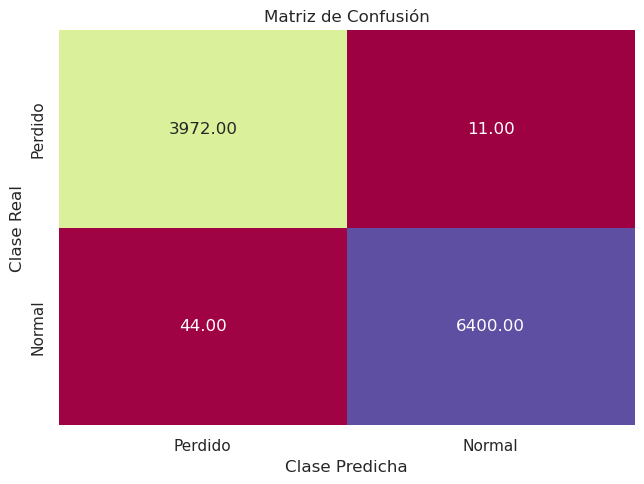

In [725]:
# Configura el formato de los números en notación decimal
sns.set(style="whitegrid")  # Establece el estilo del gráfico
colormap = sns.color_palette("Spectral", as_cmap=True)

# Crea el mapa de calor con formato decimal
sns.heatmap(df_confusion, annot=True, fmt=".2f", cbar=None, cmap=colormap)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.ylabel("Clase Real")
plt.xlabel("Clase Predicha")
plt.show()

In [726]:
print(classification_report(test_labels, target_predicted_binary))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3983
           1       1.00      0.99      1.00      6444

    accuracy                           0.99     10427
   macro avg       0.99      1.00      0.99     10427
weighted avg       0.99      0.99      0.99     10427



In [727]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

Sensitivity  = float(TP)/(TP+FN)*100
Specificity  = float(TN)/(TN+FP)*100
Precision = float(TP)/(TP+FP)*100
NPV = float(TN)/(TN+FN)*100 # Negative predictive value
FPR = float(FP)/(FP+TN)*100 # Fall out or false positive rate
FNR = float(FN)/(TP+FN)*100 # False negative rate
FDR = float(FP)/(TP+FP)*100 # False discovery rate
ACC = float(TP+TN)/(TP+FP+FN+TN)*100 # Overall accuracy
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 99.31719428926132%
Specificity or TNR: 99.72382626161185%
Precision: 99.82841990329122%
Negative Predictive Value: 98.90438247011953%
False Positive Rate: 0.2761737383881496%
False Negative Rate: 0.6828057107386716%
False Discovery Rate: 0.17158009670878177%
Accuracy: 99.47252325692912%


In [728]:
FN

44

## ROC AUC

In [729]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)

In [730]:
len(ns_probs)==len(test_labels)

True

In [731]:
# calculate AUC
auc = roc_auc_score(test_labels, target_predicted_binary)
ns_auc = roc_auc_score(test_labels,ns_probs)
print('XGBoost ROC AUC: %.3f' % auc)
print('No Skill: ROC AUC=%.3f' % (ns_auc))

XGBoost ROC AUC: 0.995
No Skill: ROC AUC=0.500


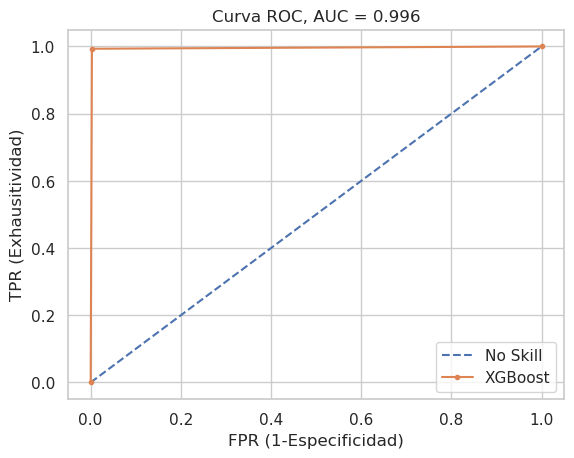

In [732]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
xg_fpr, xg_tpr, _ = roc_curve(test_labels,target_predicted_binary)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xg_fpr, xg_tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('FPR (1-Especificidad)')
plt.title('Curva ROC, AUC = 0.996')
plt.ylabel('TPR (Exhausitividad)')
# show the legend
plt.legend()
# show the plot
plt.show()

## Precision - Exhaustividad

In [733]:
# calcular curva p-r
precision, recall, thresholds = precision_recall_curve(test_labels,target_predicted_binary)

In [734]:
# calculate F1 score
f1_1= f1_score(test_labels,target_predicted_binary)

In [735]:
from sklearn.metrics import auc
# calculate precision-recall AUC
auc_1 = auc(recall, precision)

In [736]:
auc_1

0.9978379779350462

In [737]:
# summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (f1_1, auc_1))

XGBoost: f1=0.996 auc=0.998


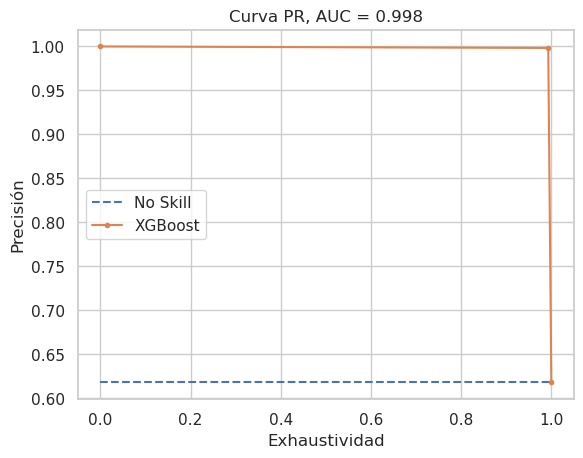

In [738]:
# plot the precision-recall curves
no_skill = len(test_labels[test_labels==1]) / len(test_labels)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall,precision, marker='.', label='XGBoost')
# axis labels
plt.xlabel('Exhaustividad')
plt.ylabel('Precisión')
plt.title('Curva PR, AUC = 0.998')
# show the legend
plt.legend()
# show the plot
plt.show()

In [739]:
import pkg_resources
import subprocess

# Obtener una lista de todos los paquetes instalados y sus versiones
installed_packages = [package for package in pkg_resources.working_set]

for package in installed_packages:
    print(f"{package.key}=={package.version}")

babel==2.12.1
bottleneck==1.3.7
cython==3.0.0
flask==2.3.2
flask-cors==4.0.0
jinja2==3.1.2
markupsafe==2.1.3
pillow==9.4.0
pyqt5==5.15.7
pyqt5-sip==12.11.0
pyqtwebengine==5.15.4
pysocks==1.7.1
pywavelets==1.4.1
pyyaml==6.0
pygments==2.15.1
qdarkstyle==3.1
qtawesome==1.2.3
qtpy==2.3.1
rtree==1.0.1
sqlalchemy==2.0.19
secretstorage==3.3.3
send2trash==1.8.2
tbb==0.2
unidecode==1.3.6
werkzeug==2.3.6
xlsxwriter==3.1.2
aiohttp==3.8.4
aiosignal==1.3.1
alabaster==0.7.13
anyio==3.7.1
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
astroid==2.15.6
astropy==5.3.1
asttokens==2.2.1
async-lru==2.0.3
async-timeout==4.0.2
atomicwrites==1.4.1
attrs==23.1.0
autopep8==2.0.2
autovizwidget==0.20.5
awscli==1.29.41
backcall==0.2.0
backports.functools-lru-cache==1.6.5
beautifulsoup4==4.12.2
binaryornot==0.4.4
bitarray==2.7.6
black==23.7.0
bleach==6.0.0
blinker==1.6.2
bokeh==3.2.0
boto3==1.28.41
botocore==1.31.41
brotlipy==0.7.0
cached-property==1.5.2
certifi==2023.5.7
cffi==1.15.1
chardet==5.1.0
